In [1]:
#Surprise
from surprise import SVD, KNNBasic, Dataset, Reader
from surprise.model_selection import train_test_split, cross_validate
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.accuracy import rmse
# Importar librerías necesarias
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import copy
from collections import defaultdict
# Librerías de Scikit-learn
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from surprise.accuracy import rmse

<p style="font-size:50px;">Anàlisi i neteja del dataset</p>

Importació i visualització de les dades del dataest amb que treballarem.

Neteja del dataset per comprovar possibles valors repetits o null.

Filtratge del dataset per treballar amb usuaris i items considerats rellevants.

In [2]:
df = pd.read_csv("ratings_Electronics.csv", names=['userId', 'productId','rating','timestamp'])

np.random.seed(42)

In [3]:
df_save = df
df = df_save
print(df.head())

           userId   productId  rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200


In [4]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 7824482
Total Columns: 4


In [5]:
print("\nEstadístiques dels ratings:") #Rang de valors dels ratings del dataset
print("Minimum rating:", df["rating"].min())
print("Maximum rating:", df["rating"].max())


Estadístiques dels ratings:
Minimum rating: 1.0
Maximum rating: 5.0


In [6]:
print("Total number of ratings:",df.rating.unique()) #Visualització de quants valors diferents trobem a cada columna del dataset
print("Total number of users:", df.userId.nunique())
print("Total number of products:", df.productId.nunique())

Total number of ratings: [5. 1. 3. 2. 4.]
Total number of users: 4201696
Total number of products: 476002


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [8]:
# Comprovar si hi ha valors null
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [9]:
# Comprovar si hi ha valors duplicats
df[df.duplicated()].any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [10]:
# Descripció dels ratings: Quants hi ha, mitjana, desviació típica i percentils
df.describe()['rating']

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [11]:
# Mitjana de la nota de cada producte
ratings = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings['n_ratings'] = pd.DataFrame(df.groupby('productId')['rating'].count())
ratings['mitjana'] = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings.head(10)
# Average rating of products
ratings = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings['Nombre_de_valoracions'] = pd.DataFrame(df.groupby('productId')['rating'].count())
ratings['ratings_average'] = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings.head(10)

,rating,Nombre_de_valoracions,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852
0558835155,3.000000,1,3.000000
059400232X,5.000000,3,5.000000
0594012015,2.000000,8,2.000000
0594017343,1.000000,1,1.000000


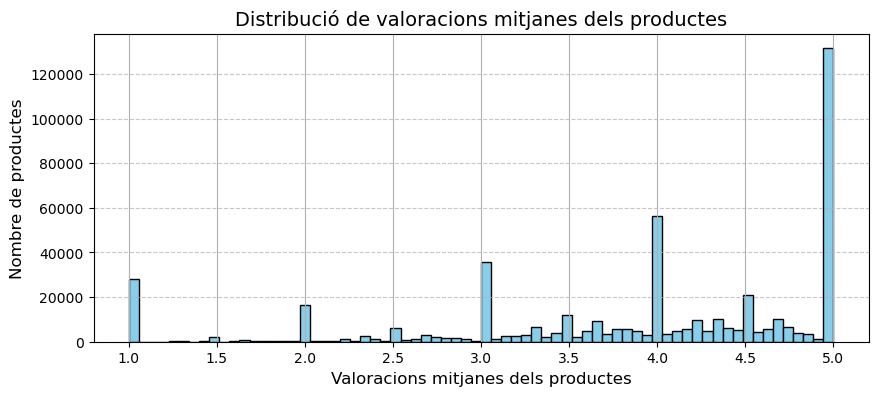

In [12]:
plt.figure(figsize=(10, 4))
ratings['rating'].hist(bins=70, color='skyblue', edgecolor='black')
plt.xlabel("Valoracions mitjanes dels productes", fontsize=12)
plt.ylabel("Nombre de productes", fontsize=12)
plt.title("Distribució de valoracions mitjanes dels productes", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

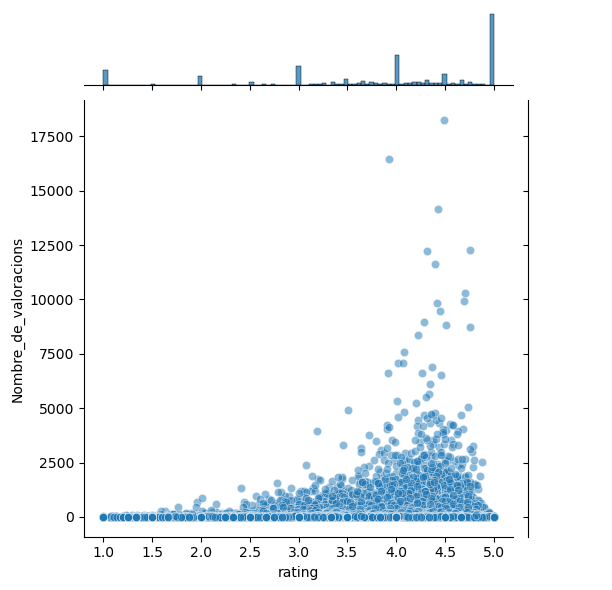

In [13]:
sns.jointplot(x='rating',y='Nombre_de_valoracions',data=ratings,alpha=0.5)

<Axes: title={'center': 'Top 30 Productes amb Més Valoracions'}, xlabel='productId'>

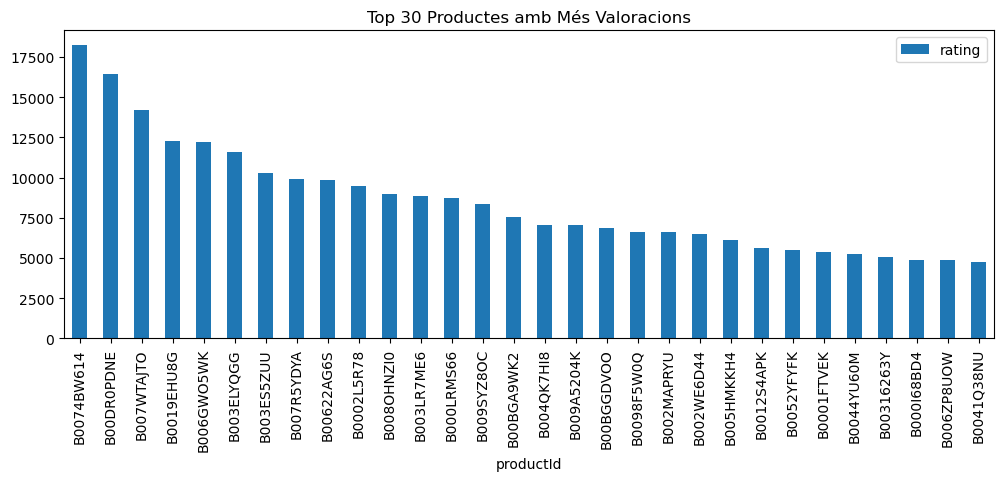

In [14]:
# Top 30 productes més popilars
popular_products = pd.DataFrame(df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind="bar", figsize=(12, 4), title="Top 30 Productes amb Més Valoracions")

In [93]:
#Filtratge del dataset
# Comptem quantes valoracions ha fet cada usuari i quantes valoracions ha rebut cada producte
user_counts = df['userId'].value_counts()  # Nombre total de valoracions per a cada usuari
product_counts = df['productId'].value_counts()  # Nombre total de valoracions per a cada producte

# Filtrar el dataset:
# - Mantenim només els usuaris que han fet almenys 50 valoracions
# - Mantenim només els productes que han rebut almenys 5 valoracions
filtered_dataset = df[(df['userId'].isin(user_counts[user_counts >= 50].index)) & 
                      (df['productId'].isin(product_counts[product_counts >= 5].index))]

# Imprimir estadístiques del dataset filtrat
print("Nombre total de valoracions:", filtered_dataset['rating'].nunique())  # Total de valoracions diferents
print("Nombre total d'usuaris:", filtered_dataset['userId'].nunique())  # Nombre d'usuaris únics
print("Nombre total de productes:", filtered_dataset['productId'].nunique())  # Nombre de productes únics


Nombre total de valoracions: 5
Nombre total d'usuaris: 1540
Nombre total de productes: 39939


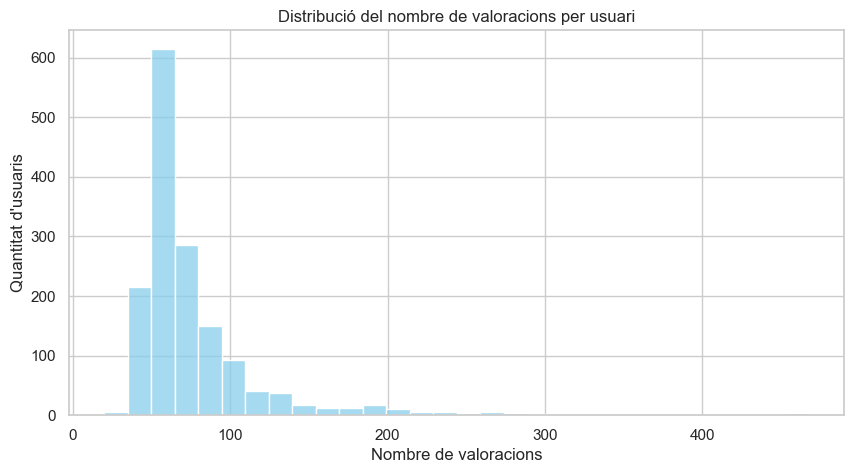

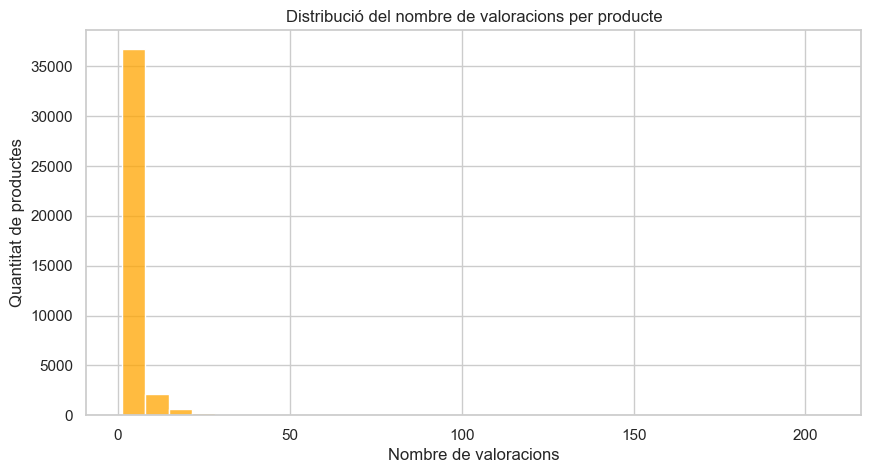

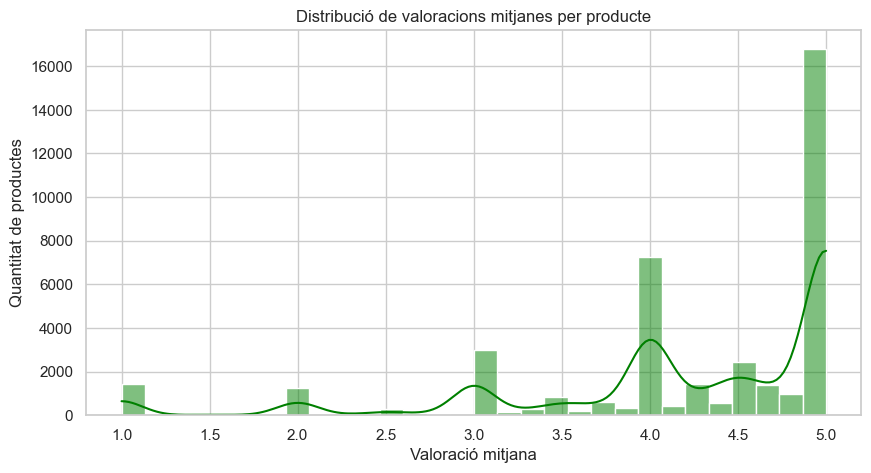

In [16]:
# Configuració general de l'estil dels gràfics
sns.set(style="whitegrid")  # Estil amb quadrícula per fer els gràfics més llegibles

# 1. Distribució del nombre de valoracions per usuari
plt.figure(figsize=(10, 5))
sns.histplot(filtered_dataset['userId'].value_counts(), bins=30, kde=False, color='skyblue')
plt.title('Distribució del nombre de valoracions per usuari')
plt.xlabel('Nombre de valoracions')
plt.ylabel("Quantitat d'usuaris")
plt.show()

# 2. Distribució del nombre de valoracions per producte
plt.figure(figsize=(10, 5))
sns.histplot(filtered_dataset['productId'].value_counts(), bins=30, kde=False, color='orange')
plt.title('Distribució del nombre de valoracions per producte')
plt.xlabel('Nombre de valoracions')
plt.ylabel('Quantitat de productes')
plt.show()

# 3. Distribució de les valoracions mitjanes per producte
avg_ratings = filtered_dataset.groupby('productId')['rating'].mean()  
# Calcular la mitjana de les valoracions per a cada producte

plt.figure(figsize=(10, 5))
sns.histplot(avg_ratings, bins=30, kde=True, color='green')
plt.title('Distribució de valoracions mitjanes per producte')
plt.xlabel('Valoració mitjana')
plt.ylabel('Quantitat de productes')
plt.show()

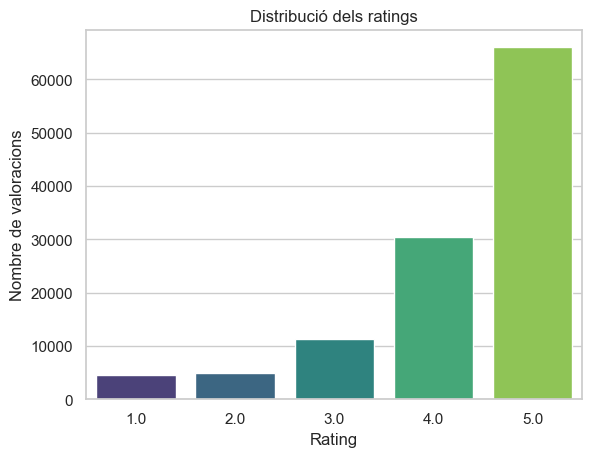

In [17]:
# Gràfic per comptar la distribució de les valoracions (ratings) al dataset filtrat
sns.countplot(data=filtered_dataset, x='rating', palette='viridis')  
plt.title("Distribució dels ratings")
plt.xlabel("Rating")
plt.ylabel("Nombre de valoracions")
plt.show()

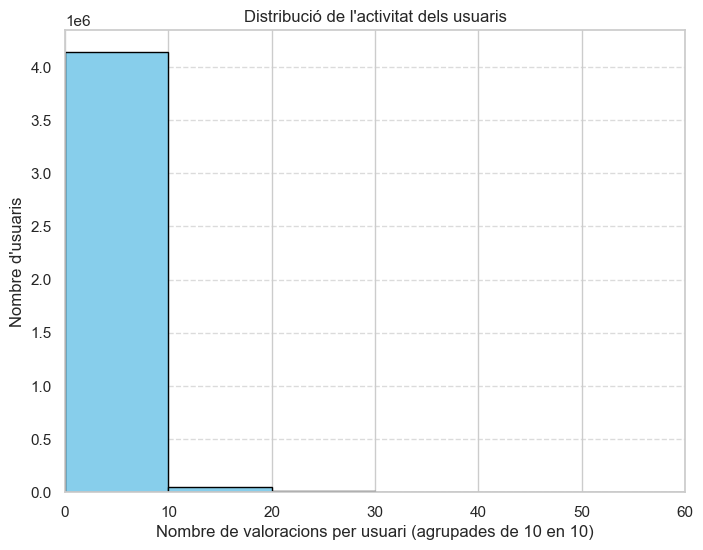

In [88]:
# Comptar el nombre de valoracions per usuari
user_activity = df['userId'].value_counts()

# Crear intervals agrupats de 10 en 10 (de 0 a 150)
bins = np.arange(0, 160, 10)  # Intervals: 0-10, 10-20, ..., 140-150

# Crear la gràfica
plt.figure(figsize=(8, 6))
plt.hist(user_activity, bins=bins, color='skyblue', edgecolor='black')  # Agrupar en intervals de 10
plt.title("Distribució de l'activitat dels usuaris")
plt.xlabel("Nombre de valoracions per usuari (agrupades de 10 en 10)")
plt.ylabel("Nombre d'usuaris")
plt.xticks(bins)  # Etiquetes de l'eix X segons els intervals
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(0,60)
plt.show()


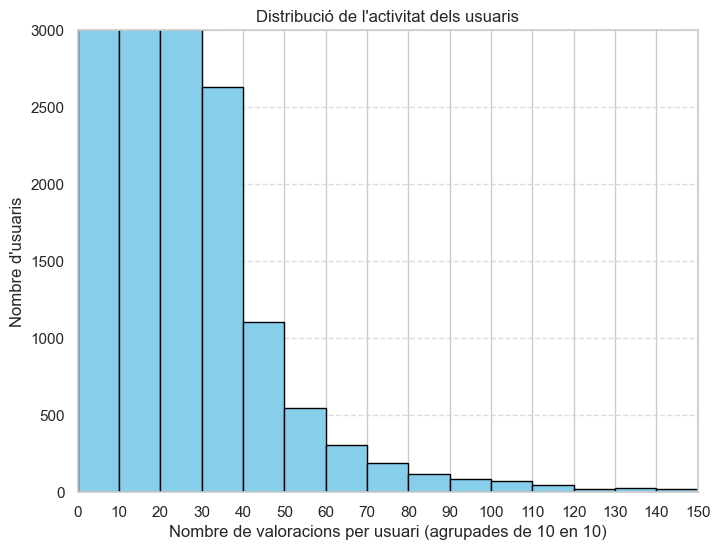

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Comptar el nombre de valoracions per usuari
user_activity = df['userId'].value_counts()

# Crear intervals agrupats de 10 en 10 (de 0 a 150)
bins = np.arange(0, 160, 10)  # Intervals: 0-10, 10-20, ..., 140-150

# Crear la gràfica
plt.figure(figsize=(8, 6))
plt.hist(user_activity, bins=bins, color='skyblue', edgecolor='black')  # Agrupar en intervals de 10
plt.title("Distribució de l'activitat dels usuaris")
plt.xlabel("Nombre de valoracions per usuari (agrupades de 10 en 10)")
plt.ylabel("Nombre d'usuaris")
plt.xticks(bins)  # Etiquetes de l'eix X segons els intervals
plt.xlim(0, 150) 
plt.ylim(0, 3000)  # Establir límit de l'eix Y
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


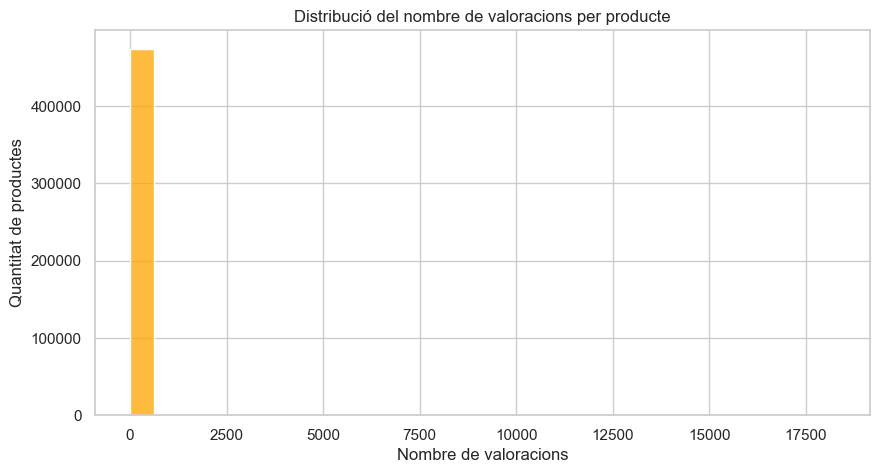

In [76]:
# 3. Distribució del nombre de valoracions per producte (sense filtrar)
plt.figure(figsize=(10, 5))
sns.histplot(df['productId'].value_counts(), bins=30, kde=False, color='orange')
plt.title('Distribució del nombre de valoracions per producte')
plt.xlabel('Nombre de valoracions')
plt.ylabel('Quantitat de productes')
plt.show()


<p style="font-size:50px;">Divisió del dataset i preparació dels models</p>

In [19]:
# Definir el rang de les qualificacions del dataset
reader = Reader(rating_scale=(1, 5))

# Convertir el dataset filtrat al format compatible amb la llibreria Surprise
data = Dataset.load_from_df(filtered_dataset[['userId', 'productId', 'rating']], reader)

"""# Crear el conjunt complet d'entrenament a partir del dataset
full_trainset = data.build_full_trainset()"""

# Dividir el dataset en conjunts d'entrenament i prova (80% entrenament, 20% prova)
trainset, testset = train_test_split(data, test_size=0.2, random_state = 42)
kf = KFold(n_splits=5, random_state=42, shuffle=True)

In [20]:
svd = SVD()
svd.fit(trainset)
pred = svd.test(testset)

In [21]:
#User-User
sim_options_cosinus = {'name': 'cosine', 'user_based': True} #Distancia cosinus
sim_options_pearson = {'name': 'pearson', 'user_based': True} #Distancia pearson

#Item-Item
sim_options_cosinus_items = {'name': 'cosine', 'user_based': False} #Distancia cosinus
sim_options_pearson_items = {'name': 'pearson', 'user_based': False} #Distancia pearson 

<p style="font-size:30px;">Anàlisi per trobar el nombre de k veins similars òptims per als sistemes recomanadors USER - USER i ITEM - ITEM</p>

    ITEM - ITEM: COSINUS (K = NOMBRE VEÏNS SIMILARS)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2386
MAE:  0.8394
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1457
MAE:  0.8093
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1197
MAE:  0.7974
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1084
MAE:  0.7929
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1018
MAE:  0.7894
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0981
MAE:  0.7878
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0953
MAE:  0.7856
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0932
MAE:  0.7842
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0917
MAE:  0.7836
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 

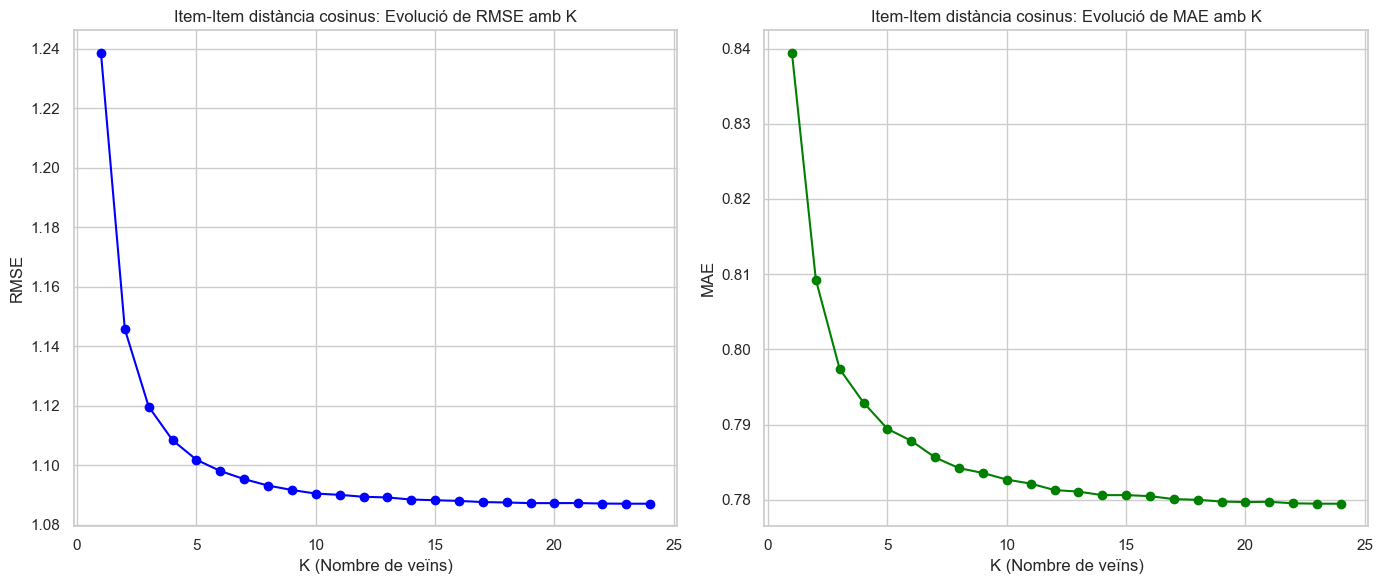

In [22]:
# Valors de K que es provaran, de 1 a 25
k_values = list(range(1, 25))
rmse_values = []  # Llista per emmagatzemar els valors de RMSE
mae_values = []   # Llista per emmagatzemar els valors de MAE

# Provar diferents valors de K
sim_options = {'name': 'cosine', 'user_based': False}  # Opcions de similitud (cosinus, Item-Item)
for k in k_values:
    # Configurar el model KNN amb el valor de K actual
    model = KNNBasic(k=k, sim_options=sim_options)
    
    # Ajustar el model i fer prediccions
    model.fit(trainset)  # Entrenar el model amb el conjunt d'entrenament
    predictions = model.test(testset)  # Fer les prediccions sobre el conjunt de test
    
    # Calcular RMSE i MAE
    rmse = accuracy.rmse(predictions)  # Calcular RMSE
    mae = accuracy.mae(predictions)    # Calcular MAE
    
    # Guardar els resultats
    rmse_values.append(rmse)
    mae_values.append(mae)

# Graficar els resultats de RMSE i MAE
plt.figure(figsize=(14, 6))

# Gràfic RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, label='RMSE', color='blue', marker='o')
plt.title('Item-Item distància cosinus: Evolució de RMSE amb K')
plt.xlabel('K (Nombre de veïns)')
plt.ylabel('RMSE')
plt.grid(True)

# Gràfic MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, label='MAE', color='green', marker='o')
plt.title('Item-Item distància cosinus: Evolució de MAE amb K')
plt.xlabel('K (Nombre de veïns)')
plt.ylabel('MAE')
plt.grid(True)

# Ajustar l'espai entre gràfics
plt.tight_layout()
plt.show()

    ITEM - ITEM: PEARSON (K = NOMBRE VEÏNS SIMILARS)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1126
MAE:  0.8360
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0942
MAE:  0.8293
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0895
MAE:  0.8272
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0878
MAE:  0.8261
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0873
MAE:  0.8258
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0871
MAE:  0.8256
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0870
MAE:  0.8255
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0870
MAE:  0.8255
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0869
MAE:  0.8255
Computing the pearson similarity matrix...
Done computing similarity matr

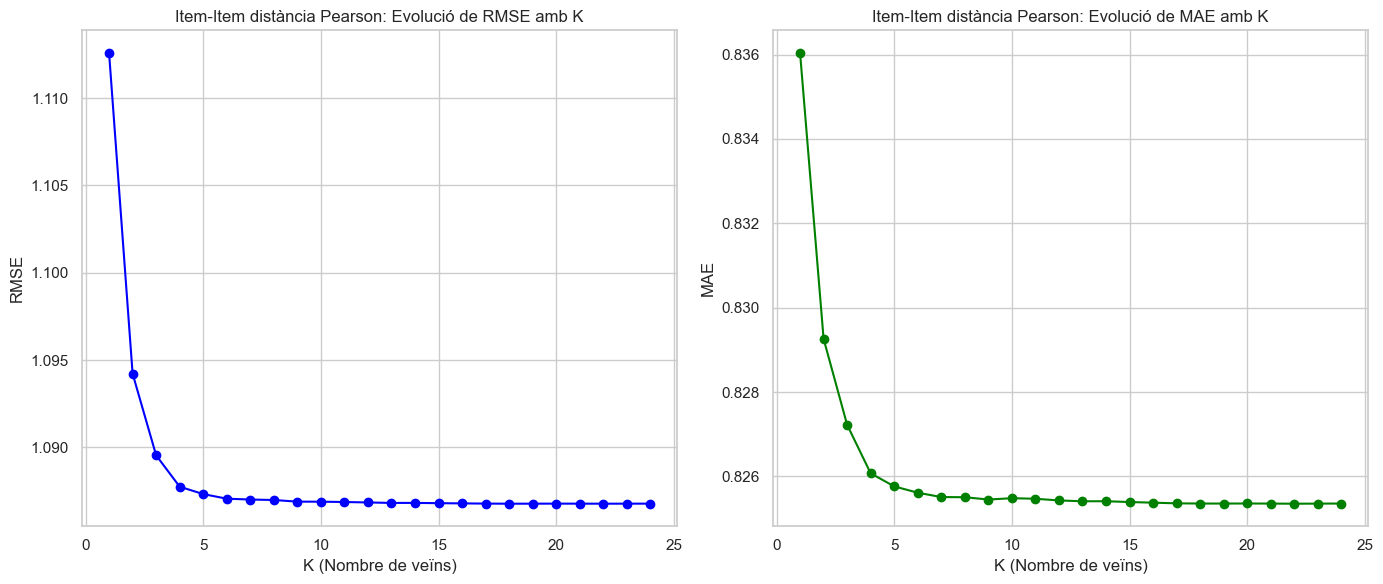

In [23]:
# Valors de K que es provaran, de 1 a 25
k_values = list(range(1, 25))
rmse_values = []  # Llista per emmagatzemar els valors de RMSE
mae_values = []   # Llista per emmagatzemar els valors de MAE

# Provar diferents valors de K
sim_options = {'name': 'pearson', 'user_based': False}  # Opcions de similitud (Pearson, Item-Item)
for k in k_values:
    # Configurar el model KNN amb el valor de K actual
    model = KNNBasic(k=k, sim_options=sim_options)
    
    # Ajustar el model i fer prediccions
    model.fit(trainset)  # Entrenar el model amb el conjunt d'entrenament
    predictions = model.test(testset)  # Fer les prediccions sobre el conjunt de test
    
    # Calcular RMSE i MAE
    rmse = accuracy.rmse(predictions)  # Calcular RMSE
    mae = accuracy.mae(predictions)    # Calcular MAE
    
    # Guardar els resultats
    rmse_values.append(rmse)
    mae_values.append(mae)

# Graficar els resultats de RMSE i MAE
plt.figure(figsize=(14, 6))

# Gràfic RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, label='RMSE', color='blue', marker='o')
plt.title('Item-Item distància Pearson: Evolució de RMSE amb K')
plt.xlabel('K (Nombre de veïns)')
plt.ylabel('RMSE')
plt.grid(True)

# Gràfic MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, label='MAE', color='green', marker='o')
plt.title('Item-Item distància Pearson: Evolució de MAE amb K')
plt.xlabel('K (Nombre de veïns)')
plt.ylabel('MAE')
plt.grid(True)

# Ajustar l'espai entre gràfics
plt.tight_layout()
plt.show()

    USER - USER: COSINUS (K = NOMBRE VEÏNS SIMILARS)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2377
MAE:  0.8432
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1546
MAE:  0.8172
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1332
MAE:  0.8086
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1227
MAE:  0.8036
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1180
MAE:  0.8003
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1150
MAE:  0.7984
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1135
MAE:  0.7976
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1121
MAE:  0.7966
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.1112
MAE:  0.7963
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 

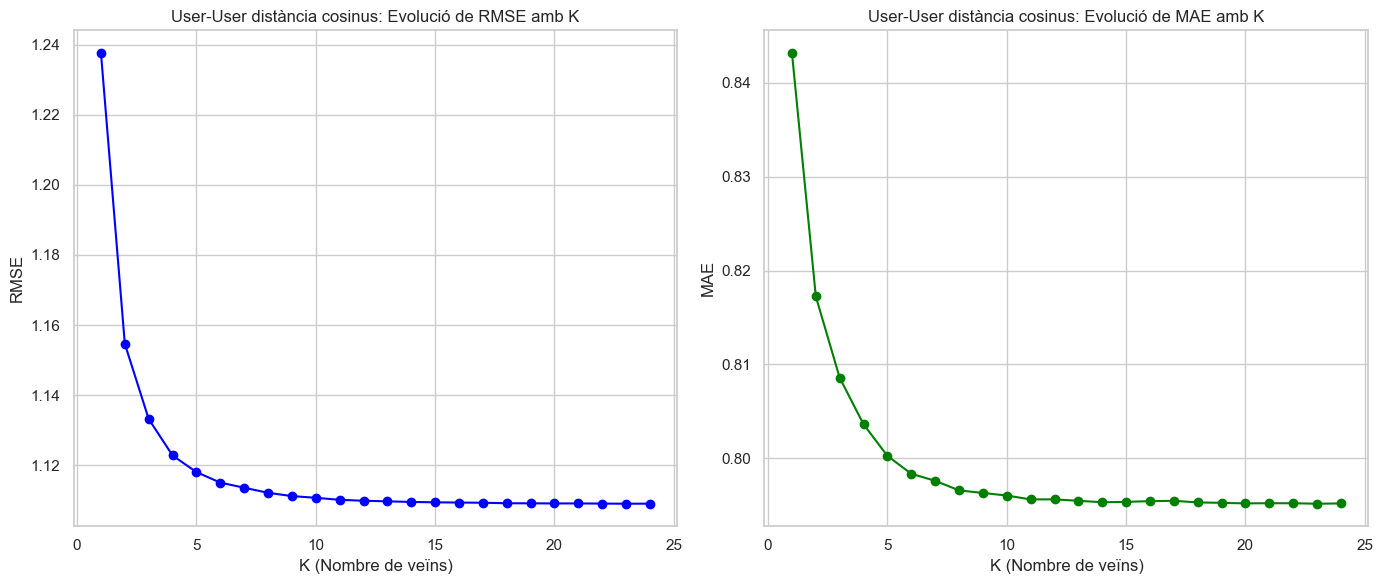

In [24]:
# Valors de K que es provaran, de 1 a 25
k_values = list(range(1, 25))  # Els valors de K van de 1 a 25
rmse_values = []  # Llista per emmagatzemar els valors de RMSE
mae_values = []   # Llista per emmagatzemar els valors de MAE

# Opcions de similitud per a l'algorisme KNN (cosinus i basat en usuaris)
sim_options = {'name': 'cosine', 'user_based': True}  # Similitud cosinus per a recomanacions basades en usuaris

# Provar diferents valors de K
for k in k_values:
    # Configurar el model KNN amb el valor de K actual
    model = KNNBasic(k=k, sim_options=sim_options)
    
    # Ajustar el model amb el conjunt d'entrenament i fer prediccions
    model.fit(trainset)  # Entrenar el model amb el conjunt d'entrenament
    predictions = model.test(testset)  # Fer les prediccions sobre el conjunt de test
    
    # Calcular les mètriques de rendiment RMSE i MAE
    rmse = accuracy.rmse(predictions)  # Calcular RMSE
    mae = accuracy.mae(predictions)    # Calcular MAE
    
    # Guardar els resultats
    rmse_values.append(rmse)
    mae_values.append(mae)

# Graficar els resultats de RMSE i MAE
plt.figure(figsize=(14, 6))

# Gràfic RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, label='RMSE', color='blue', marker='o')
plt.title('User-User distància cosinus: Evolució de RMSE amb K')
plt.xlabel('K (Nombre de veïns)')
plt.ylabel('RMSE')
plt.grid(True)

# Gràfic MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, label='MAE', color='green', marker='o')
plt.title('User-User distància cosinus: Evolució de MAE amb K')
plt.xlabel('K (Nombre de veïns)')
plt.ylabel('MAE')
plt.grid(True)

# Ajustar l'espai entre els gràfics
plt.tight_layout()
plt.show()

    USER - USER: PEARSON (K = NOMBRE VEÏNS SIMILARS)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1250
MAE:  0.8390
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.1002
MAE:  0.8291
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0946
MAE:  0.8262
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0932
MAE:  0.8253
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0925
MAE:  0.8249
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0921
MAE:  0.8246
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0918
MAE:  0.8245
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0917
MAE:  0.8244
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.0917
MAE:  0.8244
Computing the pearson similarity matrix...
Done computing similarity matr

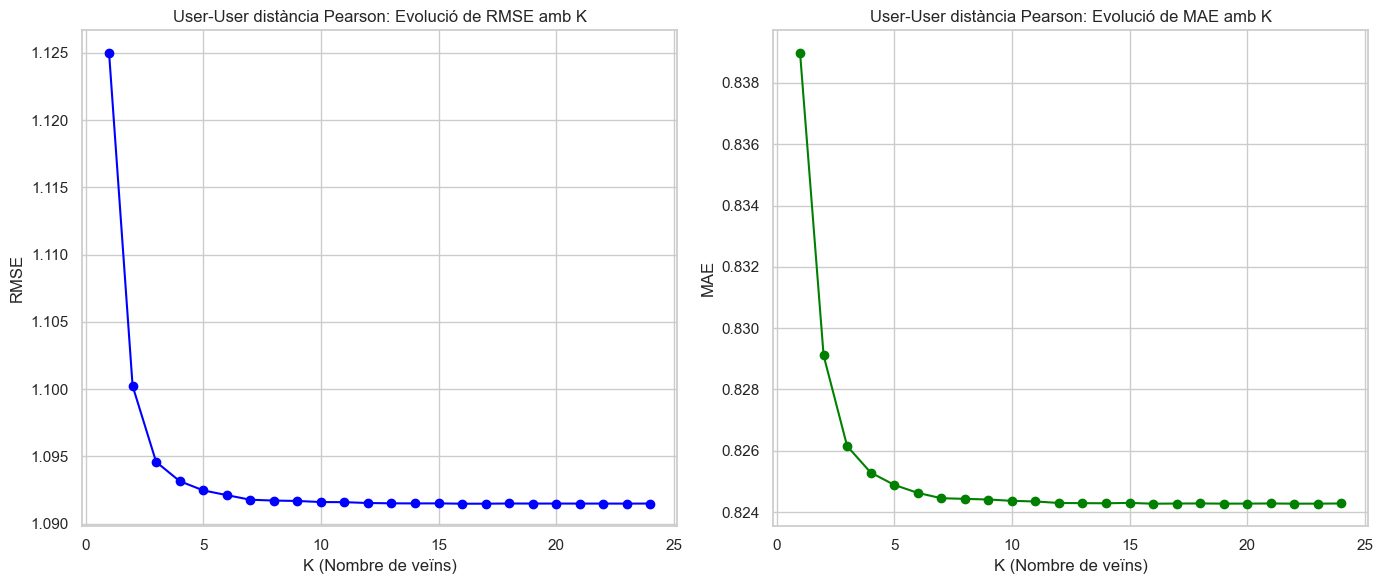

In [25]:
# Valors de K que es provaran, de 1 a 25
k_values = list(range(1, 25))  # Els valors de K van de 1 a 25
rmse_values = []  # Llista per emmagatzemar els valors de RMSE
mae_values = []   # Llista per emmagatzemar els valors de MAE

# Provar diferents valors de K
for k in k_values:
    # Configurar el model KNN amb el valor de K actual
    sim_options = {'name': 'pearson', 'user_based': True}  # Opcions de similitud (Pearson, User-User)
    model = KNNBasic(k=k, sim_options=sim_options)  # Crear el model KNN amb el valor de K i les opcions de similitud
    
    # Ajustar el model amb el conjunt d'entrenament i fer prediccions
    model.fit(trainset)  # Entrenar el model amb el conjunt d'entrenament
    predictions = model.test(testset)  # Fer les prediccions sobre el conjunt de test
    
    # Calcular les mètriques de rendiment RMSE i MAE
    rmse = accuracy.rmse(predictions)  # Calcular RMSE
    mae = accuracy.mae(predictions)    # Calcular MAE
    
    # Guardar els resultats
    rmse_values.append(rmse)
    mae_values.append(mae)

# Graficar els resultats de RMSE i MAE
plt.figure(figsize=(14, 6))

# Gràfic RMSE
plt.subplot(1, 2, 1)
plt.plot(k_values, rmse_values, label='RMSE', color='blue', marker='o')
plt.title('User-User distància Pearson: Evolució de RMSE amb K')
plt.xlabel('K (Nombre de veïns)')
plt.ylabel('RMSE')
plt.grid(True)

# Gràfic MAE
plt.subplot(1, 2, 2)
plt.plot(k_values, mae_values, label='MAE', color='green', marker='o')
plt.title('User-User distància Pearson: Evolució de MAE amb K')
plt.xlabel('K (Nombre de veïns)')
plt.ylabel('MAE')
plt.grid(True)

# Ajustar l'espai entre els gràfics
plt.tight_layout()
plt.show()


<p style="font-size:20px;">Per seleccionar la k òptima s'ha fet servir el mètode del colze, seleccionant el valor on l'error s'estabilitza. En l'informe es es fa una explicació detallada d'aquest mètode i dels motius que ens han portat a pendre aquestes decisions (Apartats 6.1.1 i 6.1.2)</p>
<p style="font-size:30px;">ITEM - ITEM</p>
<p style="font-size:20px;">Decisió de k òptima per la distància del Cosinus: k = 5</p>
<p style="font-size:20px;">Decisió de k òptima per la distància de Pearson: k = 4</p>
<p style="font-size:30px;">USER - USER</p>
<p style="font-size:20px;">Decisió de k òptima per la distància del Cosinus: k = 5</p>
<p style="font-size:20px;">Decisió de k òptima per la distància de Pearson: k = 4</p>

<p style="font-size:30px;">Anàlisi per trobar el nombre de k factors latents òptims per al sistema recomanador SVD</p>

    SVD (K = FACTORS LATENTS)

In [26]:
#SVD k FACTORS LATENTS PER DEFECTE
print(f"El valor per defecte de K (n_factors): {svd.n_factors}")

El valor per defecte de K (n_factors): 100


Entrenant model amb K=1...
RMSE: 0.9732
Entrenant model amb K=2...
RMSE: 0.9734
Entrenant model amb K=3...
RMSE: 0.9735
Entrenant model amb K=4...
RMSE: 0.9732
Entrenant model amb K=5...
RMSE: 0.9737
Entrenant model amb K=6...
RMSE: 0.9741
Entrenant model amb K=7...
RMSE: 0.9733
Entrenant model amb K=8...
RMSE: 0.9743
Entrenant model amb K=9...
RMSE: 0.9740
Entrenant model amb K=10...
RMSE: 0.9738
Entrenant model amb K=11...
RMSE: 0.9739
Entrenant model amb K=12...
RMSE: 0.9742
Entrenant model amb K=13...
RMSE: 0.9745
Entrenant model amb K=14...
RMSE: 0.9740
Entrenant model amb K=15...
RMSE: 0.9742
Entrenant model amb K=16...
RMSE: 0.9742
Entrenant model amb K=17...
RMSE: 0.9742
Entrenant model amb K=18...
RMSE: 0.9745
Entrenant model amb K=19...
RMSE: 0.9751
Entrenant model amb K=20...
RMSE: 0.9745
Entrenant model amb K=21...
RMSE: 0.9734
Entrenant model amb K=22...
RMSE: 0.9754
Entrenant model amb K=23...
RMSE: 0.9748
Entrenant model amb K=24...
RMSE: 0.9757
Entrenant model amb K=25.

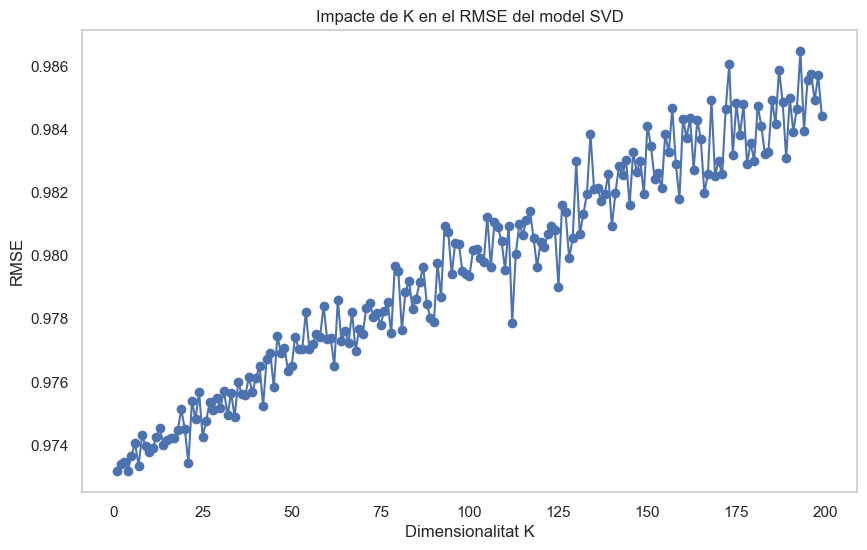

In [27]:
from surprise.accuracy import rmse
######################Tercer veiem que es fa relativament ràpid, 
# fem gràfica passant per tots els valors ja que comportament estrany tot i que lleugerament creixent######################

# Valors de K a provar
k_values = [i for i in range(1, 200)]  # Crear una llista amb els valors de K de 1 a 250
rmse_values = []  # Llista per emmagatzemar els valors de RMSE

# Bucle per avaluar diferents valors de K
for k in k_values:
    print(f"Entrenant model amb K={k}...")  # Mostrar el valor de K actual
    svd = SVD(n_factors=k)  # Crear el model SVD amb el número de factors latents igual a K

    # Entrenar el model amb el conjunt d'entrenament
    svd.fit(trainset)

    # Avaluar el model amb el conjunt de test
    predictions = svd.test(testset)  # Fer prediccions sobre el conjunt de test
    error = rmse(predictions, verbose=True)  # Calcular l'error RMSE
    rmse_values.append(error)  # Afegir el valor de RMSE a la llista

# Graficar l'impacte de K en el RMSE
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='b')
plt.title("Impacte de K en el RMSE del model SVD")
plt.xlabel("Dimensionalitat K")
plt.ylabel("RMSE")
plt.grid()
plt.show()

##Resultat##
# Valors molt irregulars. Decidim fer validació creuada.

Entrenant model amb K=10...
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9691  0.9823  0.9560  0.9689  0.9743  0.9701  0.0086  
Fit time          0.35    0.37    0.37    0.35    0.35    0.36    0.01    
Test time         0.08    0.08    0.07    0.08    0.08    0.08    0.00    
Entrenant model amb K=20...
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9698  0.9832  0.9569  0.9699  0.9744  0.9708  0.0085  
Fit time          0.48    0.41    0.46    0.42    0.43    0.44    0.03    
Test time         0.08    0.07    0.08    0.07    0.08    0.08    0.00    
Entrenant model amb K=50...
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9732  0.9854  0.9584  0.9713  0.9766  0.9730  0.0088  
Fit time          0

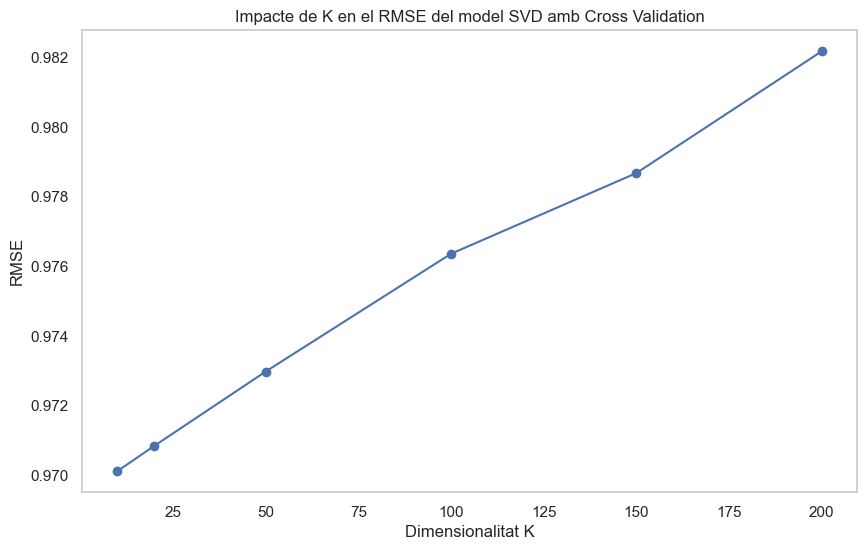

In [28]:
######################Segon, avaluem l'evolució amb pocs valors de K######################

# Llista de valors específics de K per explorar com afecta la dimensionalitat en l'error del model
k_values = [10, 20, 50, 100, 150, 200]
rmse_values = []

# Entrenem el model SVD amb diferents valors de factors latents (K) i utilitzem cross-validation
for k in k_values:
    print(f"Entrenant model amb K={k}...")
    algo = SVD(n_factors=k)
    cv_results = cross_validate(algo, data, measures=['RMSE'], cv=kf, verbose=True)
    mean_rmse = np.mean(cv_results['test_rmse'])  # Obtenim la mitjana del RMSE per a cada K
    rmse_values.append(mean_rmse)

# Representem l'impacte del nombre de factors latents (K) en el RMSE del model
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='b')
plt.title("Impacte de K en el RMSE del model SVD amb Cross Validation")
plt.xlabel("Dimensionalitat K")
plt.ylabel("RMSE")
plt.grid()
plt.show()



Avaluant model amb K=1 usant validació creuada...
K=1, RMSE promig: 0.9693
Avaluant model amb K=2 usant validació creuada...
K=2, RMSE promig: 0.9693
Avaluant model amb K=3 usant validació creuada...
K=3, RMSE promig: 0.9694
Avaluant model amb K=4 usant validació creuada...
K=4, RMSE promig: 0.9694
Avaluant model amb K=5 usant validació creuada...
K=5, RMSE promig: 0.9695
Avaluant model amb K=6 usant validació creuada...
K=6, RMSE promig: 0.9696
Avaluant model amb K=7 usant validació creuada...
K=7, RMSE promig: 0.9698
Avaluant model amb K=8 usant validació creuada...
K=8, RMSE promig: 0.9701
Avaluant model amb K=9 usant validació creuada...
K=9, RMSE promig: 0.9700
Avaluant model amb K=10 usant validació creuada...
K=10, RMSE promig: 0.9698
Avaluant model amb K=11 usant validació creuada...
K=11, RMSE promig: 0.9701
Avaluant model amb K=12 usant validació creuada...
K=12, RMSE promig: 0.9701
Avaluant model amb K=13 usant validació creuada...
K=13, RMSE promig: 0.9704
Avaluant model am

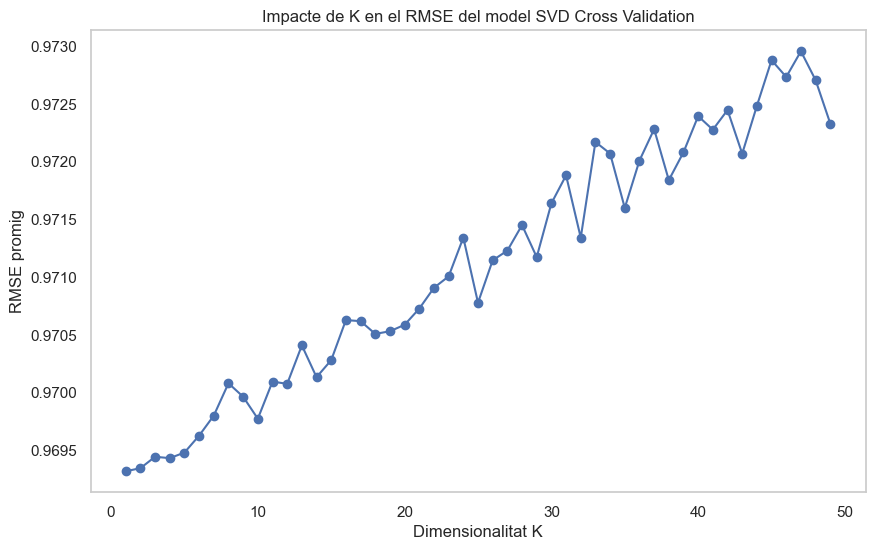

In [29]:
######################Quart, fem cross-validation######################

# Llista de valors de K a provar per explorar com afecta la dimensionalitat al rendiment del model
k_values = [i for i in range(1, 50)]
rmse_values = []

# Avaluació del model per a cada valor de K amb cross-validation
for k in k_values:
    print(f"Avaluant model amb K={k} usant validació creuada...")
    svd = SVD(n_factors=k)  # Ajustar el nombre de factors latents

    # Realitzar cross-validation per calcular l'error RMSE
    cv_results = cross_validate(svd, data, measures=['RMSE'], cv=kf, verbose=False)

    # Calcular el RMSE promig obtingut durant la validació
    mean_rmse = cv_results['test_rmse'].mean()
    rmse_values.append(mean_rmse)

    print(f"K={k}, RMSE promig: {mean_rmse:.4f}")

# Representació gràfica de l'impacte del nombre de factors latents (K) en el RMSE del model
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_values, marker='o', linestyle='-', color='b')
plt.title("Impacte de K en el RMSE del model SVD Cross Validation")
plt.xlabel("Dimensionalitat K")
plt.ylabel("RMSE promig")
plt.grid()
plt.show()

Avaluant model amb K=1 usant validació creuada...
K=1, MAE promig: 0.7150
Avaluant model amb K=2 usant validació creuada...
K=2, MAE promig: 0.7150
Avaluant model amb K=3 usant validació creuada...
K=3, MAE promig: 0.7152
Avaluant model amb K=4 usant validació creuada...
K=4, MAE promig: 0.7153
Avaluant model amb K=5 usant validació creuada...
K=5, MAE promig: 0.7155
Avaluant model amb K=6 usant validació creuada...
K=6, MAE promig: 0.7154
Avaluant model amb K=7 usant validació creuada...
K=7, MAE promig: 0.7153
Avaluant model amb K=8 usant validació creuada...
K=8, MAE promig: 0.7154
Avaluant model amb K=9 usant validació creuada...
K=9, MAE promig: 0.7156
Avaluant model amb K=10 usant validació creuada...
K=10, MAE promig: 0.7157
Avaluant model amb K=11 usant validació creuada...
K=11, MAE promig: 0.7158
Avaluant model amb K=12 usant validació creuada...
K=12, MAE promig: 0.7160
Avaluant model amb K=13 usant validació creuada...
K=13, MAE promig: 0.7159
Avaluant model amb K=14 usant 

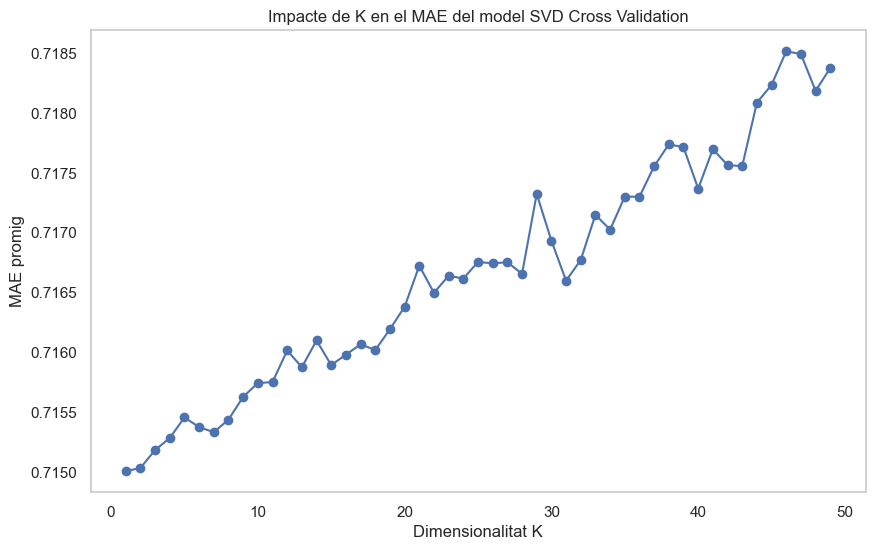

In [30]:
######################Quart, fem cross-validation######################

# Valors de K a provar per explorar com afecta la dimensionalitat al rendiment del model
k_values = [i for i in range(1, 50)]
mae_values = []

# Avaluació del model per a cada valor de K amb cross-validation
for k in k_values:
    print(f"Avaluant model amb K={k} usant validació creuada...")
    svd = SVD(n_factors=k)  # Ajustar el nombre de factors latents

    # Realitzar cross-validation per calcular l'error MAE
    cv_results = cross_validate(svd, data, measures=['MAE'], cv=kf, verbose=False)

    # Calcular el MAE promig obtingut durant la validació
    mean_mae = cv_results['test_mae'].mean()
    mae_values.append(mean_mae)

    print(f"K={k}, MAE promig: {mean_mae:.4f}")

# Representació gràfica de l'impacte del nombre de factors latents (K) en el MAE del model
plt.figure(figsize=(10, 6))
plt.plot(k_values, mae_values, marker='o', linestyle='-', color='b')
plt.title("Impacte de K en el MAE del model SVD Cross Validation")
plt.xlabel("Dimensionalitat K")
plt.ylabel("MAE promig")
plt.grid()
plt.show()

##Resultat##
# Observem uns valors més constants i menys aleatoris.
# Conclusió: segons augmenta K, l'error també augmenta de forma directament proporcional.


Millors paràmetres segons RMSE: {'n_factors': 1, 'reg_all': 0.02}
Millor RMSE: 0.9692585872131024

Millors paràmetres segons MAE: {'n_factors': 1, 'reg_all': 0.02}
Millor MAE: 0.7150208484696753


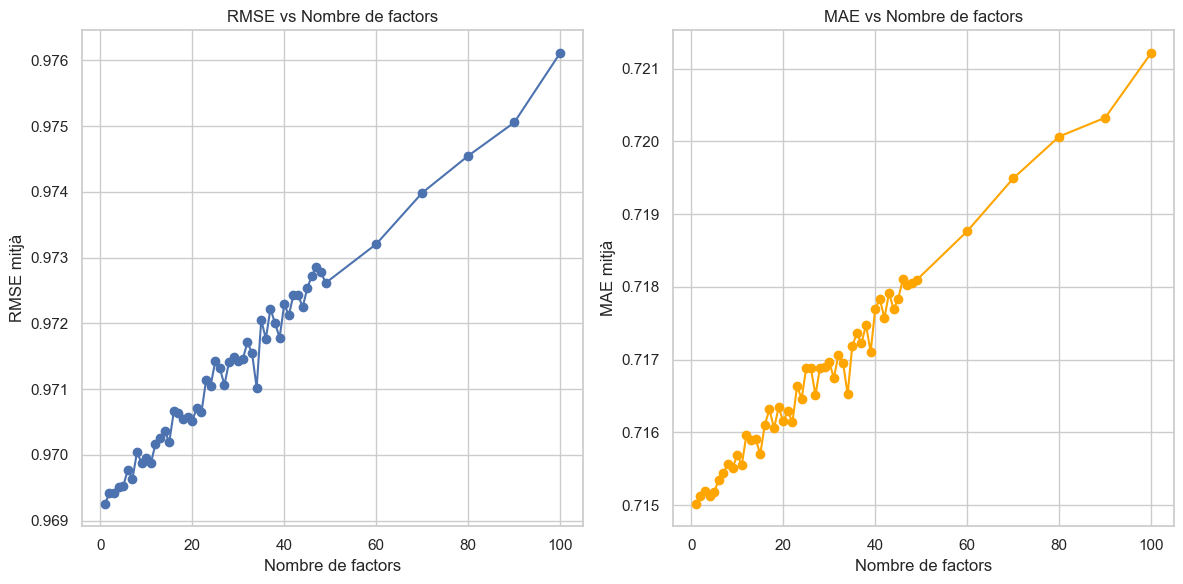

In [31]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import GridSearchCV
import pandas as pd
import matplotlib.pyplot as plt

ddd = Dataset.load_from_df(filtered_dataset[['userId', 'productId', 'rating']], reader)

# Definim un conjunt de paràmetres per al GridSearch
param_grid = {
    'n_factors': [i for i in range(1, 50)] + [60, 70, 80, 90, 100],  # Nombre de factors latents
    'reg_all': [0.02]  # Regularització constant
}

# Crear el GridSearchCV per trobar els millors paràmetres
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=kf)
gs.fit(ddd)

# Mostrar els millors paràmetres
print("Millors paràmetres segons RMSE:", gs.best_params['rmse'])
print("Millor RMSE:", gs.best_score['rmse'])
print("\nMillors paràmetres segons MAE:", gs.best_params['mae'])
print("Millor MAE:", gs.best_score['mae'])

# Convertir els resultats a un DataFrame per facilitar la visualització
results_df = pd.DataFrame(gs.cv_results)

plt.figure(figsize=(12, 6))
# Gràfic per RMSE
plt.subplot(1, 2, 1)
rmse_means = results_df.pivot_table(values='mean_test_rmse',index='param_n_factors')
plt.plot(rmse_means.index, rmse_means.values, marker='o', label='RMSE')  # Dibuixar línia
plt.xlabel('Nombre de factors')
plt.ylabel('RMSE mitjà')
plt.title('RMSE vs Nombre de factors')
plt.grid(True)  # Afegir graella

# Gràfic per MAE
plt.subplot(1, 2, 2)
mae_means = results_df.pivot_table(values='mean_test_mae', index='param_n_factors')
plt.plot(mae_means.index, mae_means.values, marker='o', color='orange', label='MAE')  # Dibuixar línia
plt.xlabel('Nombre de factors')
plt.ylabel('MAE mitjà')
plt.title('MAE vs Nombre de factors')
plt.grid(True)  # Afegir graella

# Ajustar l'espai entre els gràfics
plt.tight_layout()
plt.show()

<p style="font-size:20px;">En aquest cas no s'ha pogut fer servir el mètode del colze. En l'informe hi ha una explicació detallada de totes les proves realitzades en aquest apartat i del perquè de la decisió de n = 6 (Apartat 6.1.3)</p>
<p style="font-size:30px;">SVD</p>
<p style="font-size:20px;">Decisió de n òptima: n = 6</p>

<p style="font-size:50px;">Entrenament i test dels models de recomanació</p>

In [32]:
# Models
model_cosinus_i = KNNBasic(k=5, sim_options=sim_options_cosinus_items)  # Model Item-Item amb similitud cosinus
model_cosinus_u = KNNBasic(k=5, sim_options=sim_options_cosinus)  # Model User-User amb similitud cosinus
model_pearson_u = KNNBasic(k=4, sim_options=sim_options_pearson)  # Model User-User amb similitud Pearson
model_pearson_i = KNNBasic(k=4, sim_options=sim_options_pearson_items)  # Model Item-Item amb similitud Pearson
svd = SVD(n_factors = 6)  # Model basat en descomposició de valors singulars (SVD)

# Entrenar els models amb el conjunt d'entrenament i fer prediccions pel conjunt de test. Mesurem el temps d'execució dels models.

start_time = time.time()
model_cosinus_i.fit(trainset)
predictions_cosinus_i = model_cosinus_i.test(testset)
time_cosinus_i = time.time() - start_time

start_time = time.time()
model_cosinus_u.fit(trainset)
predictions_cosinus_u = model_cosinus_u.test(testset)
time_cosinus_u = time.time() - start_time

start_time = time.time()
model_pearson_u.fit(trainset)
predictions_pearson_u = model_pearson_u.test(testset)
time_pearson_u = time.time() - start_time

start_time = time.time()
model_pearson_i.fit(trainset)
predictions_pearson_i = model_pearson_i.test(testset)
time_pearson_i = time.time() - start_time

start_time = time.time()
svd.fit(trainset)
pred = svd.test(testset)
time_svd = time.time() - start_time

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [33]:
# Calcular RMSE i MAE per a cada model
# Es mesuren les mètriques d'error (RMSE i MAE) per a cadascun dels models amb les prediccions realitzades.

print("Model Cosinus Items:")
rmse_c_i = accuracy.rmse(predictions_cosinus_i, verbose=True)  # RMSE per al model basat en distància cosinus (Item-Item)
mae_c_i = accuracy.mae(predictions_cosinus_i, verbose=True)  # MAE per al model basat en distància cosinus (Item-Item)

print("\nModel Cosinus Users:")
rmse_c_u = accuracy.rmse(predictions_cosinus_u, verbose=True)  # RMSE per al model basat en distància cosinus (User-User)
mae_c_u = accuracy.mae(predictions_cosinus_u, verbose=True)  # MAE per al model basat en distància cosinus (User-User)

print("\nModel Pearson Users:")
rmse_pearson_u = accuracy.rmse(predictions_pearson_u, verbose=True)  # RMSE per al model basat en correlació Pearson (User-User)
mae_pearson_u = accuracy.mae(predictions_pearson_u, verbose=True)  # MAE per al model basat en correlació Pearson (User-User)

print("\nModel Pearson Items:")
rmse_pearson_i = accuracy.rmse(predictions_pearson_i, verbose=True)  # RMSE per al model basat en correlació Pearson (Item-Item)
mae_pearson_i = accuracy.mae(predictions_pearson_i, verbose=True)  # MAE per al model basat en correlació Pearson (Item-Item)

print("\nModel SVD:")
rmse_svd = accuracy.rmse(pred, verbose=True)  # RMSE per al model SVD
mae_svd = accuracy.mae(pred, verbose=True)  # MAE per al model SVD

# Mostrar els resultats
# Es presenten els resultats finals de les mètriques calculades (RMSE i MAE) per a cada model.
print("\nResum de RMSE i MAE:")
print(f"Cosinus Items - RMSE: {rmse_c_i:.4f}, MAE: {mae_c_i:.4f}")
print(f"Cosinus Users - RMSE: {rmse_c_u:.4f}, MAE: {mae_c_u:.4f}")
print(f"Pearson Users - RMSE: {rmse_pearson_u:.4f}, MAE: {mae_pearson_u:.4f}")
print(f"Pearson Items - RMSE: {rmse_pearson_i:.4f}, MAE: {mae_pearson_i:.4f}")
print(f"SVD - RMSE: {rmse_svd:.4f}, MAE: {mae_svd:.4f}")


Model Cosinus Items:
RMSE: 1.1018
MAE:  0.7894

Model Cosinus Users:
RMSE: 1.1180
MAE:  0.8003

Model Pearson Users:
RMSE: 1.0932
MAE:  0.8253

Model Pearson Items:
RMSE: 1.0878
MAE:  0.8261

Model SVD:
RMSE: 0.9735
MAE:  0.7184

Resum de RMSE i MAE:
Cosinus Items - RMSE: 1.1018, MAE: 0.7894
Cosinus Users - RMSE: 1.1180, MAE: 0.8003
Pearson Users - RMSE: 1.0932, MAE: 0.8253
Pearson Items - RMSE: 1.0878, MAE: 0.8261
SVD - RMSE: 0.9735, MAE: 0.7184


In [34]:
def precision_recall_at_k(predictions, k=10, threshold=4):
    """
    Calcula Precision@K i Recall@K per a les prediccions donades.
    """
    # Mapejar cada usuari als ítems recomanats
    user_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_recs[uid].append((iid, est, true_r))
    
    # Ordenar les prediccions per qualificació estimada i limitar a les top-k
    for uid, user_ratings in user_recs.items():
        user_recs[uid] = sorted(user_ratings, key=lambda x: x[1], reverse=True)[:k]
    
    precisions = {}
    recalls = {}
    for uid, user_ratings in user_recs.items():
        # Calcular ítems recomanats rellevants
        recommended_and_relevant = [
            (iid, est) for (iid, est, true_r) in user_ratings if true_r >= threshold
        ]
        
        # Total d'ítems rellevants al conjunt de veritat
        relevant_total = sum(
            1 for u, _, true_r, _, _ in predictions if u == uid and true_r >= threshold
        )
        
        # Precision i Recall
        precisions[uid] = len(recommended_and_relevant) / k if k > 0 else 0
        recalls[uid] = len(recommended_and_relevant) / relevant_total if relevant_total > 0 else 0
    
    return precisions, recalls

def precision_recall_by_k(predictions, max_k=30, threshold=4):
    """
    Calcula Precision@K i Recall@K per a valors de K des de 1 fins a max_k.
    """
    precision_at_k = []
    recall_at_k = []

    for k in range(1, max_k + 1):
        # Calcular Precision i Recall per cada valor de K
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=threshold)
        avg_precision = sum(precisions.values()) / len(precisions)
        avg_recall = sum(recalls.values()) / len(recalls)
        
        precision_at_k.append(avg_precision)
        recall_at_k.append(avg_recall)

    return precision_at_k, recall_at_k

max_k = 30
# Calcular Precision@K i Recall@K per al model SVD
precisions_svd, recalls_svd = precision_recall_at_k(pred, k=10, threshold=4)
# Promig de les mètriques
avg_precision_svd = sum(precisions_svd.values()) / len(precisions_svd)
avg_recall_svd = sum(recalls_svd.values()) / len(recalls_svd)

# Calcular Precision@K i Recall@K per al model USER-USER basat en cosinus
precisions_c_u, recalls_c_u = precision_recall_at_k(predictions_cosinus_u, k=10, threshold=4)
# Promig de les mètriques
avg_precision_c_u = sum(precisions_c_u.values()) / len(precisions_c_u)
avg_recall_c_u = sum(recalls_c_u.values()) / len(recalls_c_u)

# Calcular Precision@K i Recall@K per al model ITEM-ITEM basat en cosinus
precisions_c_i, recalls_c_i = precision_recall_at_k(predictions_cosinus_i, k=10, threshold=4)
# Promig de les mètriques
avg_precision_c_i = sum(precisions_c_i.values()) / len(precisions_c_i)
avg_recall_c_i = sum(recalls_c_i.values()) / len(recalls_c_i)

# Mostrar els resultats de les mètriques per als diferents models
print(f'Precision@10: {avg_precision_svd:.4f}')
print(f'Recall@10: {avg_recall_svd:.4f}')
print(f'Precision@10: {avg_precision_c_u:.4f}')
print(f'Recall@10: {avg_recall_c_u:.4f}')
print(f'Precision@10: {avg_precision_c_i:.4f}')
print(f'Recall@10: {avg_recall_c_i:.4f}')


Precision@10: 0.8006
Recall@10: 0.7619
Precision@10: 0.7955
Recall@10: 0.7583
Precision@10: 0.7788
Recall@10: 0.7450


In [35]:
#preparació per cross validate de 0
mmodel_cosinus_i = KNNBasic(k=5, sim_options=sim_options_cosinus_items)  # Model Item-Item amb similitud cosinus
mmodel_cosinus_u = KNNBasic(k=5, sim_options=sim_options_cosinus)  # Model User-User amb similitud cosinus
mmodel_pearson_u = KNNBasic(k=4, sim_options=sim_options_pearson)  # Model User-User amb similitud Pearson
mmodel_pearson_i = KNNBasic(k=4, sim_options=sim_options_pearson_items)  # Model Item-Item amb similitud Pearson
m_svd = SVD(n_factors = 6) 
# Comparació dels diferents models amb validació creuada (cross-validation).
# Avaluem els models basats en distància cosinus i correlació de Pearson (tant User-User com Item-Item),
# així com el model SVD, utilitzant 10 particions (cv=10) i mesurant RMSE i MAE.

results_cosinus_uu = cross_validate(mmodel_cosinus_u, data, measures=['RMSE', 'MAE'], cv=kf, verbose=True)  # Cosinus User-User
results_pearson_uu = cross_validate(mmodel_pearson_u, data, measures=['RMSE', 'MAE'], cv=kf, verbose=True)  # Pearson User-User
results_pearson_i = cross_validate(mmodel_pearson_i, data, measures=['RMSE', 'MAE'], cv=kf, verbose=True)  # Pearson Item-Item
results_cosinus_i = cross_validate(mmodel_cosinus_i, data, measures=['RMSE', 'MAE'], cv=kf, verbose=True)  # Cosinus Item-Item
resutls_svd = cross_validate(m_svd, data, measures=['RMSE', 'MAE'], cv=kf, verbose=True)  # SVD

# Càlcul de les mitjanes dels resultats per a cada model i mètrica.
cv_cosinus_uu_rmse = results_cosinus_uu['test_rmse'].mean()
cv_pearson_uu_mae = results_pearson_uu['test_mae'].mean()

cv_pearson_uu_rmse = results_pearson_uu['test_rmse'].mean()
cv_cosinus_uu_mae = results_pearson_uu['test_mae'].mean()

cv_svd_rmse = resutls_svd['test_rmse'].mean()
cv_svd_mae = resutls_svd['test_mae'].mean()

cv_pearson_i_mae = results_pearson_i['test_mae'].mean()
cv_pearson_i_rmse = results_pearson_i['test_rmse'].mean()

cv_cosinus_i_rmse = results_cosinus_i['test_rmse'].mean()
cv_cosinus_i_mae = results_cosinus_i['test_mae'].mean()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1115  1.1293  1.1041  1.1079  1.1180  1.1142  0.0088  
MAE (testset)     0.7929  0.8073  0.7929  0.7933  0.8003  0.7973  0.0057  
Fit time          0.05    0.06    0.06    0.06    0.06    0.06    0.00    
Test time         0.18    0.17    0.17    0.17    0.17    0.17    0.00    
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity

<p style="font-size:50px;">Distància de Cosinus vs Distància de Pearson. Quina és millor?</p>

<p style="font-size:30px;">USER - USER</p>
<p style="font-size:20px;">RMSE i MAE per distància de Pearson vs distància de Cosinus </p>

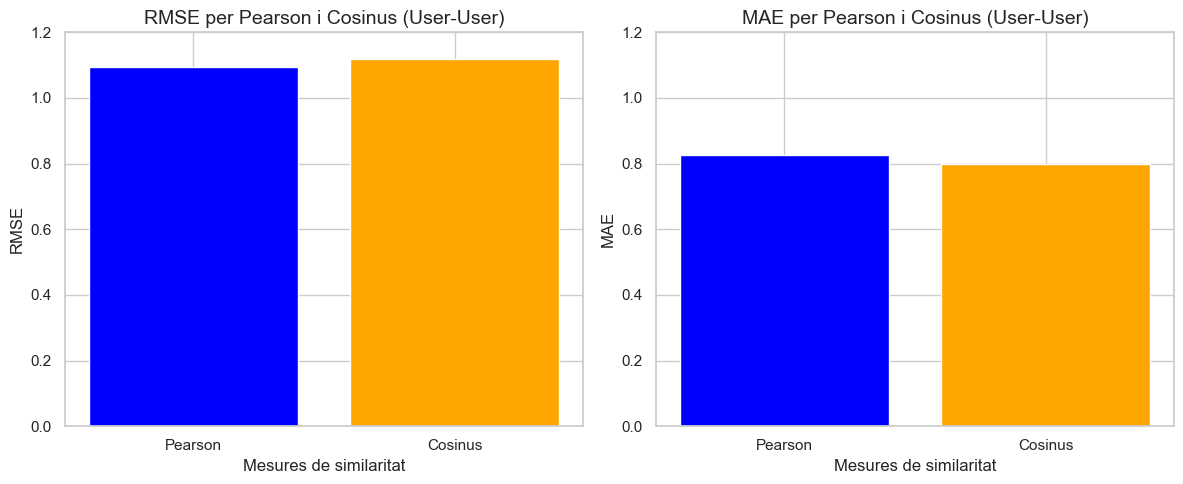

In [36]:
# Gràfica 1: RMSE
metrics = ["Pearson", "Cosinus"]
rmse_values = [rmse_pearson_u, rmse_c_u]  # Valors de RMSE per als dos models
mae_values = [mae_pearson_u, mae_c_u]    # Valors de MAE per als dos models

plt.figure(figsize=(12, 5))

# Subgràfic 1 (RMSE)
plt.subplot(1, 2, 1)
plt.bar(metrics, rmse_values, color=['blue', 'orange'], alpha=1)
plt.title('RMSE per Pearson i Cosinus (User-User)', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('Mesures de similaritat', fontsize=12)
plt.ylim(0, 1.2)

# Subgràfic 2 (MAE)
plt.subplot(1, 2, 2)
plt.bar(metrics, mae_values, color=['blue', 'orange'], alpha=1)
plt.title('MAE per Pearson i Cosinus (User-User)', fontsize=14)
plt.ylabel('MAE', fontsize=12)
plt.xlabel('Mesures de similaritat', fontsize=12)
plt.ylim(0, 1.2)

# Ajustar disseny
plt.tight_layout()  # Ajustar els espais perquè no es superposin elements
plt.show()  # Mostrar la gràfica


    Repetir la comparació fent Cross Validation

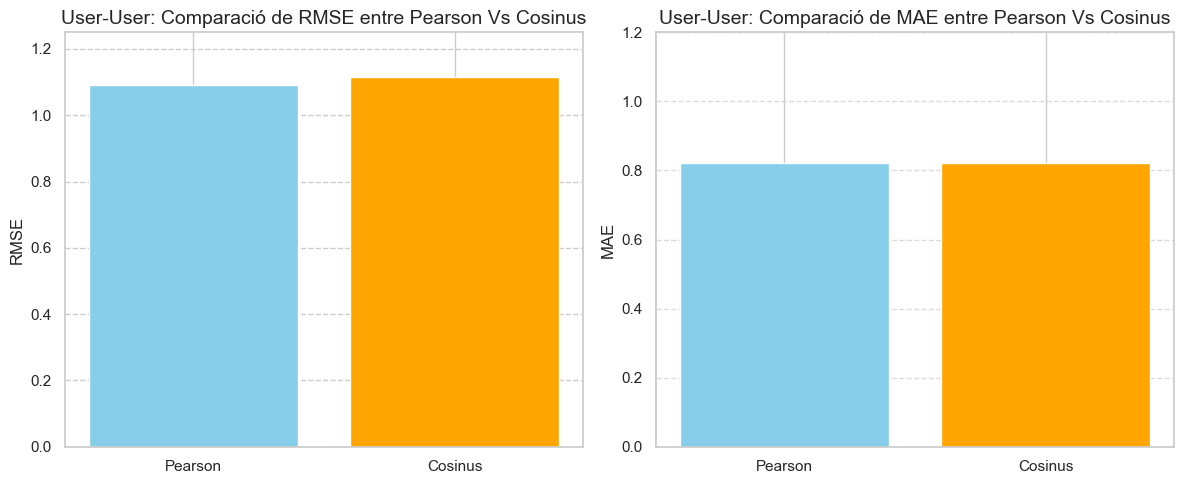

In [37]:
###USERUSER WHICH IS BETTER?? PREARSON O COSINUS

##Visualització cosinus, quin és millor: item-item o user-user?
# Dades simulades de les mètriques
models = ['Pearson', 'Cosinus']
rmse_values = [cv_pearson_uu_rmse, cv_cosinus_uu_rmse]  # RMSE per a User-User i Item-Item
mae_values = [cv_pearson_uu_mae, cv_cosinus_uu_mae]   # MAE per a User-User i Item-Item

# Gràfic 1: Comparació de RMSE
plt.figure(figsize=(12, 5))  # Estableix la mida de la figura (12x5 polzades)

# Subgràfic 1 (RMSE)
plt.subplot(1, 2, 1)  # Crea un gràfic de 1 fila i 2 columnes, seleccionant el primer espai
plt.bar(models, rmse_values, color=['skyblue', 'orange'])  # Crea un gràfic de barres per a RMSE
plt.title('User-User: Comparació de RMSE entre Pearson Vs Cosinus', fontsize=14)  # Títol del gràfic
plt.ylabel('RMSE', fontsize=12)  # Etiqueta de l'eix Y (error quadràtic mig)
plt.ylim(0, 1.25)  # Estableix els límits de l'eix Y per evitar valors innecessaris
plt.grid(axis='y', linestyle='--', alpha=1)  # Afegeix una quadrícula a l'eix Y amb línies discontínues

# Gràfic 2: Comparació de MAE
plt.subplot(1, 2, 2)  # Selecciona el segon espai del gràfic
plt.bar(models, mae_values, color=['skyblue', 'orange'])  # Crea un gràfic de barres per a MAE
plt.title('User-User: Comparació de MAE entre Pearson Vs Cosinus', fontsize=14)  # Títol del gràfic
plt.ylabel('MAE', fontsize=12)  # Etiqueta de l'eix Y (error absolut mitjà)
plt.ylim(0, 1.2)  # Estableix els límits de l'eix Y per evitar valors innecessaris
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegeix una quadrícula a l'eix Y amb opacitat 0.7

# Mostrar els gràfics
plt.tight_layout()  # Ajusta els espais perquè no es superposin elements en el disseny
plt.show()  # Mostra la figura amb els gràfics


    Fer la comparació analitzant la Precision i el Recall

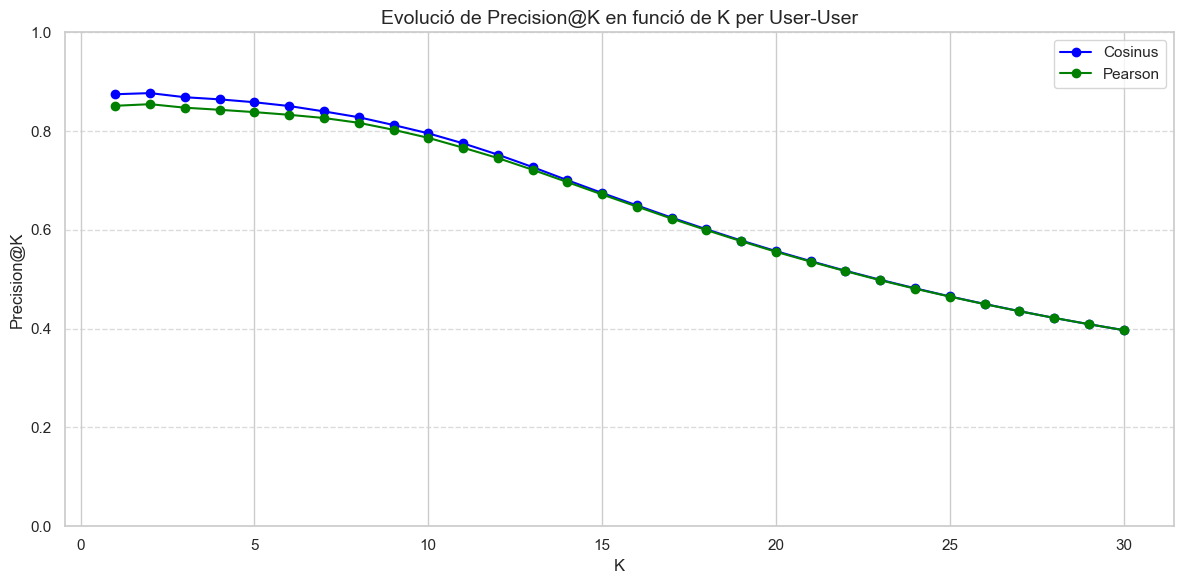

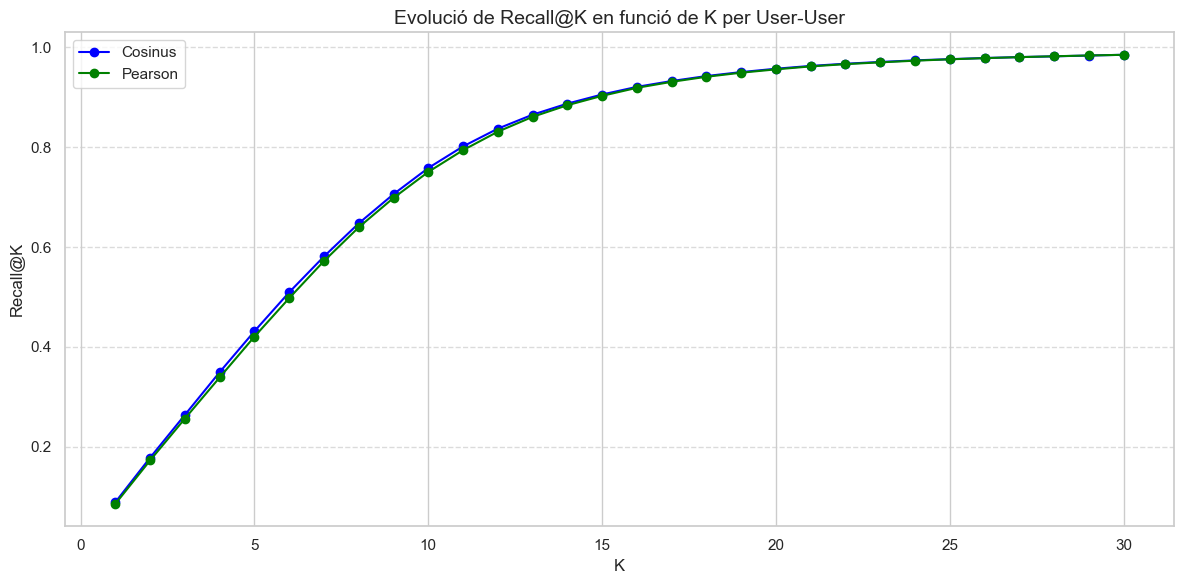

In [38]:
# Calculant Precision@K i Recall@K per a Pearson i Cosinus (User-User)
precision_k_p_u, recall_k_p_u = precision_recall_by_k(predictions_pearson_u, max_k=max_k)  # Per al model Pearson (User-User)
precision_k_c_u, recall_k_c_u = precision_recall_by_k(predictions_cosinus_u, max_k=max_k)  # Per al model Cosinus (User-User)

# (Repetir aquest càlcul per User-User o Item-Item si es necessari)

# Definim els valors de K (de 1 a max_k)
k_values = list(range(1, max_k + 1))

# Gràfic de Precision@K
plt.figure(figsize=(12, 6))  # Creem una figura de 12x6 polzades
plt.plot(k_values, precision_k_c_u, label='Cosinus', marker='o', color='blue')  # Dibuixem la corba de Precision@K per Cosinus
plt.plot(k_values, precision_k_p_u, label='Pearson', marker='o', color='green')  # Dibuixem la corba de Precision@K per Pearson
plt.title('Evolució de Precision@K en funció de K per User-User', fontsize=14)  # Títol del gràfic
plt.xlabel('K', fontsize=12)  # Etiqueta de l'eix X
plt.ylabel('Precision@K', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1)  # Limitem l'eix Y entre 0 i 1
plt.legend()  # Afegim una llegenda per identificar els models
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegeix una quadrícula a l'eix Y
plt.tight_layout()  # Ajusta els espais perquè no es superposin elements
plt.show()  # Mostrem el gràfic

# Gràfic de Recall@K
plt.figure(figsize=(12, 6))  # Creem una figura de 12x6 polzades
plt.plot(k_values, recall_k_c_u, label='Cosinus', marker='o', color='blue')  # Dibuixem la corba de Recall@K per Cosinus
plt.plot(k_values, recall_k_p_u, label='Pearson', marker='o', color='green')  # Dibuixem la corba de Recall@K per Pearson
plt.title('Evolució de Recall@K en funció de K per User-User', fontsize=14)  # Títol del gràfic
plt.xlabel('K', fontsize=12)  # Etiqueta de l'eix X
plt.ylabel('Recall@K', fontsize=12)  # Etiqueta de l'eix Y
plt.legend()  # Afegim una llegenda per identificar els models
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegeix una quadrícula a l'eix Y
plt.tight_layout()  # Ajusta els espais perquè no es superposin elements
plt.show()  # Mostrem el gràfic


<p style="font-size:30px;">ITEM - ITEM</p>
<p style="font-size:20px;">RMSE i MAE per distància de Pearson vs distància de Cosinus </p>

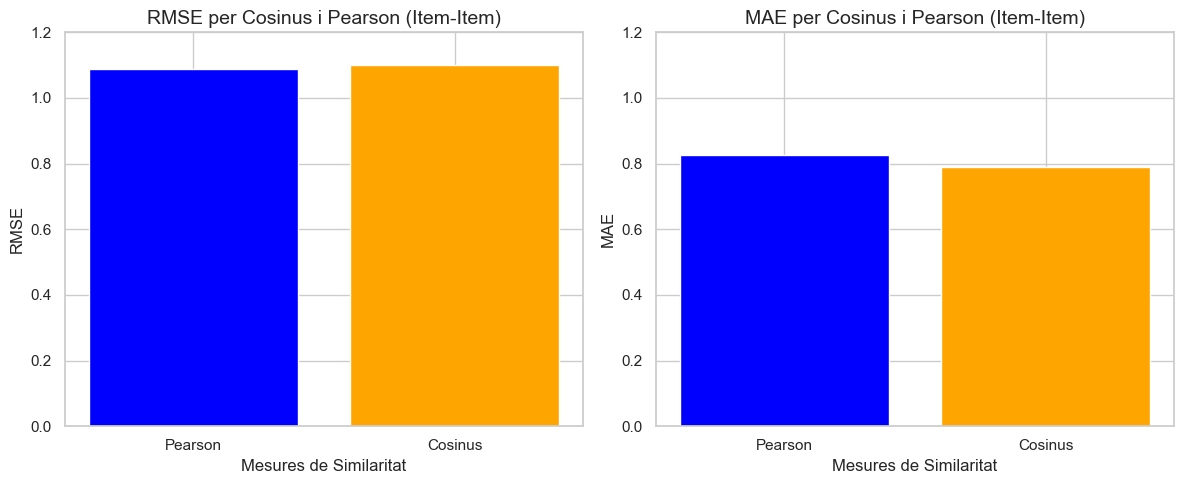

In [39]:
models = ['Pearson', 'Cosinus']
rmse_values = [rmse_pearson_i, rmse_c_i]  # Valors de RMSE per als models Cosinus i Pearson (Item-Item)
mae_values = [mae_pearson_i, mae_c_i]    # Valors de MAE per als models Cosinus i Pearson (Item-Item)

# Gràfic 1: Comparació de RMSE
plt.figure(figsize=(12, 5))  # Creem una figura de 12x5 polzades per als gràfics
plt.subplot(1, 2, 1)  # Subgràfic 1 (comparació de RMSE)
plt.bar(models, rmse_values, color=['blue', 'orange'], alpha=1)  # Gràfic de barres per a RMSE
plt.title('RMSE per Cosinus i Pearson (Item-Item)', fontsize=14)  # Títol del gràfic
plt.ylabel('RMSE', fontsize=12)  # Etiqueta de l'eix Y
plt.xlabel('Mesures de Similaritat', fontsize=12)  # Etiqueta de l'eix X
plt.ylim(0, 1.2)  # Limitem l'eix Y entre 0 i 1.2 per a una millor visibilitat

# Gràfic 2: Comparació de MAE
plt.subplot(1, 2, 2)  # Subgràfic 2 (comparació de MAE)
plt.bar(models, mae_values, color=['blue', 'orange'], alpha=1)  # Gràfic de barres per a MAE
plt.title('MAE per Cosinus i Pearson (Item-Item)', fontsize=14)  # Títol del gràfic
plt.ylabel('MAE', fontsize=12)  # Etiqueta de l'eix Y
plt.xlabel('Mesures de Similaritat', fontsize=12)  # Etiqueta de l'eix X
plt.ylim(0, 1.2)  # Limitem l'eix Y entre 0 i 1.2 per a una millor visibilitat

# Ajustar disseny
plt.tight_layout()  # Ajusta els espais per evitar superposició de contingut
plt.show()  # Mostrem els gràfics


    Repetir la comparació fent Cross Validation

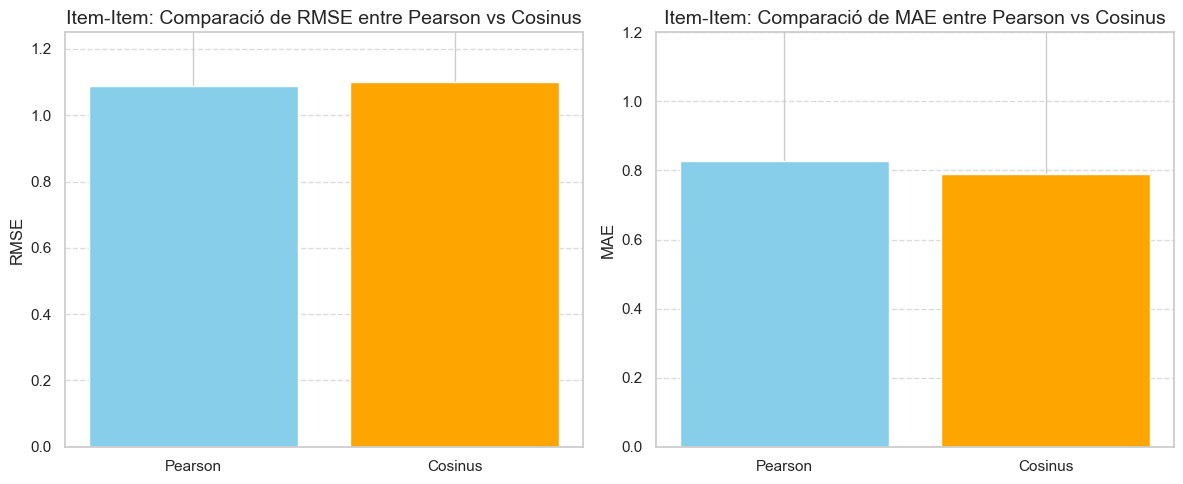

In [40]:
# Validació creuada PEARSON vs Cosinus I-I
## ITEM-ITEM: QUÈ ÉS MILLOR, PEARSON O COSINUS?
# Dades simulades de les mètriques
models = ['Pearson', 'Cosinus']  # Models a comparar: Pearson vs Cosinus
rmse_values = [cv_pearson_i_rmse, cv_cosinus_i_rmse]  # RMSE per a Pearson i Cosinus (Item-Item)
mae_values = [cv_pearson_i_mae, cv_cosinus_i_mae]    # MAE per a Pearson i Cosinus (Item-Item)

# Gràfic 1: Comparació de RMSE
plt.figure(figsize=(12, 5))  # Creem una figura de 12x5 polzades per als gràfics
plt.subplot(1, 2, 1)  # Subgràfic 1 (comparació de RMSE)
plt.bar(models, rmse_values, color=['skyblue', 'orange'])  # Gràfic de barres per a RMSE
plt.title('Item-Item: Comparació de RMSE entre Pearson vs Cosinus', fontsize=14)  # Títol del gràfic
plt.ylabel('RMSE', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1.25)  # Limitem l'eix Y entre 0 i 1.25 per a una millor visibilitat
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegim una graella per a l'eix Y

# Gràfic 2: Comparació de MAE
plt.subplot(1, 2, 2)  # Subgràfic 2 (comparació de MAE)
plt.bar(models, mae_values, color=['skyblue', 'orange'])  # Gràfic de barres per a MAE
plt.title('Item-Item: Comparació de MAE entre Pearson vs Cosinus', fontsize=14)  # Títol del gràfic
plt.ylabel('MAE', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1.2)  # Limitem l'eix Y entre 0 i 1.2 per a una millor visibilitat
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegim una graella per a l'eix Y

# Mostrar els gràfics
plt.tight_layout()  # Ajustar els espais per evitar superposició de contingut
plt.show()  # Mostrem els gràfics

    Fer la comparació analitzant la Precision i el Recall

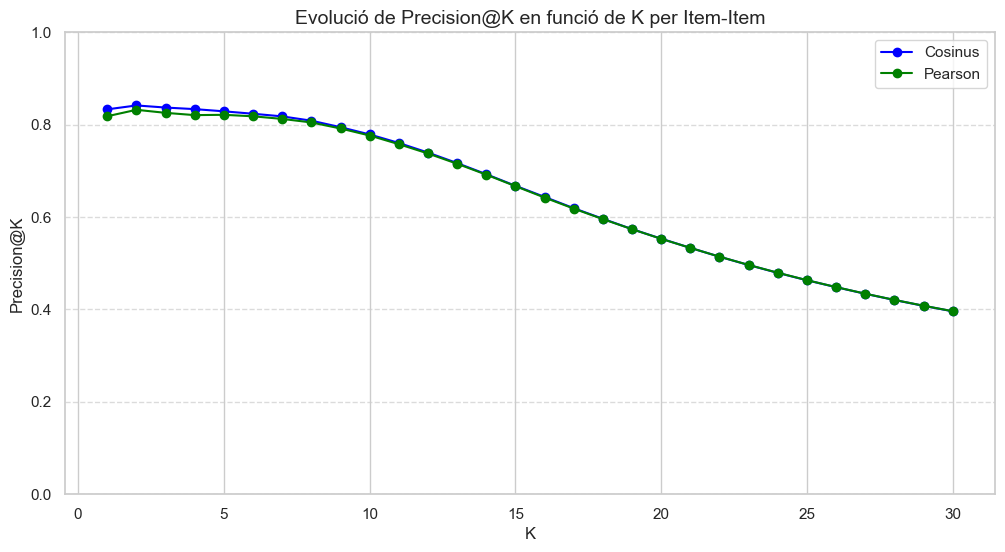

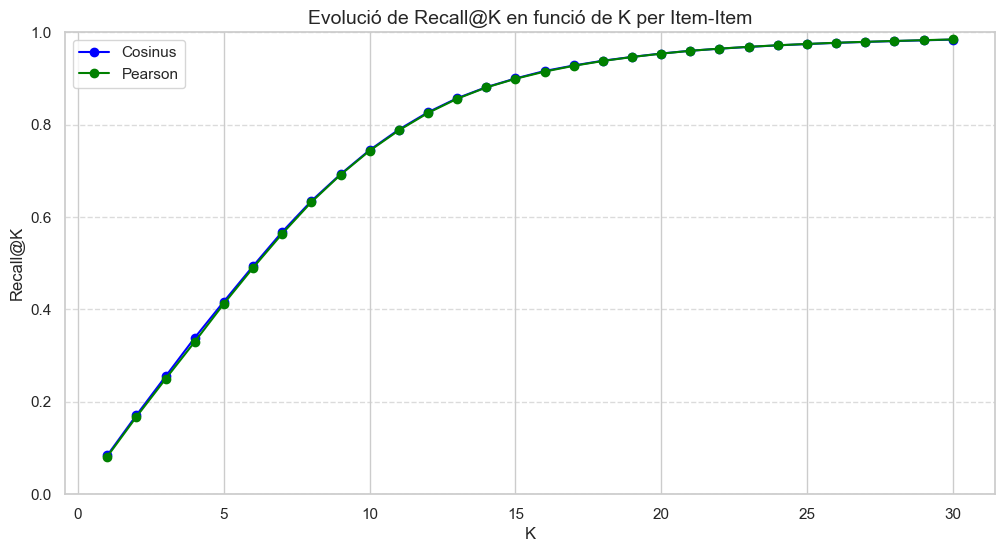

In [41]:
# Comparació de distàncies PEARSON vs COSINUS amb Precision i Recall per Item-Item
precision_k_p_i, recall_k_p_i = precision_recall_by_k(predictions_pearson_i, max_k=max_k)  # Calcular precision i recall per a Pearson (Item-Item)
precision_k_c_i, recall_k_c_i = precision_recall_by_k(predictions_cosinus_i, max_k=max_k)  # Calcular precision i recall per a Cosinus (Item-Item)

# Valors de K
k_values = list(range(1, max_k + 1))  # Generar una llista amb els valors de K (1 a max_k)

# Graficar Precision@K
plt.figure(figsize=(12, 6))  # Crear una figura de 12x6 polzades per al gràfic
plt.plot(k_values, precision_k_c_i, label='Cosinus', marker='o', color='blue')  # Dibuixar Precision per a Cosinus
plt.plot(k_values, precision_k_p_i, label='Pearson', marker='o', color='green')  # Dibuixar Precision per a Pearson
plt.title('Evolució de Precision@K en funció de K per Item-Item', fontsize=14)  # Títol del gràfic
plt.xlabel('K', fontsize=12)  # Etiqueta de l'eix X
plt.ylabel('Precision@K', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1)  # Limitar l'eix Y entre 0 i 1 per una millor visualització
plt.legend()  # Afegir llegenda per identificar les línies
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella per a l'eix Y
plt.show()  # Mostrar el gràfic de Precision@K

# Graficar Recall@K
plt.figure(figsize=(12, 6))  # Crear una figura de 12x6 polzades per al gràfic
plt.plot(k_values, recall_k_c_i, label='Cosinus', marker='o', color='blue')  # Dibuixar Recall per a Cosinus
plt.plot(k_values, recall_k_p_i, label='Pearson', marker='o', color='green')  # Dibuixar Recall per a Pearson
plt.title('Evolució de Recall@K en funció de K per Item-Item', fontsize=14)  # Títol del gràfic
plt.xlabel('K', fontsize=12)  # Etiqueta de l'eix X
plt.ylabel('Recall@K', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1)  # Limitar l'eix Y entre 0 i 1 per una millor visualització
plt.legend()  # Afegir llegenda per identificar les línies
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella per a l'eix Y
plt.show()  # Mostrar el gràfic de Recall@K


<p style="font-size:30px;">Decisió de quina distància és millor</p>
<p style="font-size:20px;">Millor distància: Són distàncies molt similars</p>
Justificació: A efectes pràctics les distàncies són pràcticament iguals. Per tant, per simplicitat de projecte continuarem amb una de les dues. En el nostre cas, Distància Cosinus. (Trobarà més informació detallada en l'informe a l'apartat 6.1.4)

<p style="font-size:50px;">Comparació dels diferents models de recomanació</p>

<p style="font-size:30px;">RMSE i MAE per comparar User - User vs Item - Item</p>

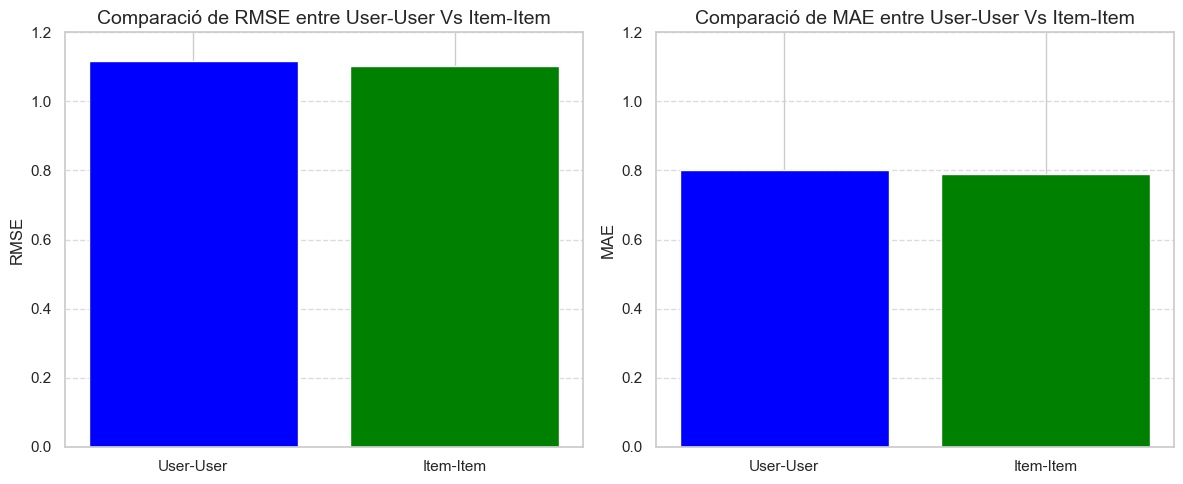

In [42]:
models = ['User-User', 'Item-Item']  # Model de tipus (User-User, Item-Item)
rmse_values = [rmse_c_u, rmse_c_i]  # RMSE per User-User i Item-Item
mae_values = [mae_c_u, mae_c_i]    # MAE per User-User i Item-Item

# Gràfic 1: Comparació de RMSE
plt.figure(figsize=(12, 5))  # Crear la figura amb un tamany de 12x5 polzades
plt.subplot(1, 2, 1)  # Subgràfic 1 (a la primera posició, 1 fila i 2 columnes)
plt.bar(models, rmse_values, color=['blue', 'green'])  # Dibuixar el gràfic de barres per RMSE
plt.title('Comparació de RMSE entre User-User Vs Item-Item', fontsize=14)  # Títol del gràfic
plt.ylabel('RMSE', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1.2)  # Limitar l'eix Y entre 0 i 1.2 per una millor visualització
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella en l'eix Y

# Gràfic 2: Comparació de MAE
plt.subplot(1, 2, 2)  # Subgràfic 2 (a la segona posició, 1 fila i 2 columnes)
plt.bar(models, mae_values, color=['blue', 'green'])  # Dibuixar el gràfic de barres per MAE
plt.title('Comparació de MAE entre User-User Vs Item-Item', fontsize=14)  # Títol del gràfic
plt.ylabel('MAE', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1.2)  # Limitar l'eix Y entre 0 i 1.2 per una millor visualització
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella en l'eix Y

# Mostrar els gràfics
plt.tight_layout()  # Ajustar els espais perquè no es superposin els elements
plt.show()  # Mostrar els gràfics


<p style="font-size:30px;">RMSE i MAE per comparar User - User vs Item - Item mitjanjant Cross Validation</p>

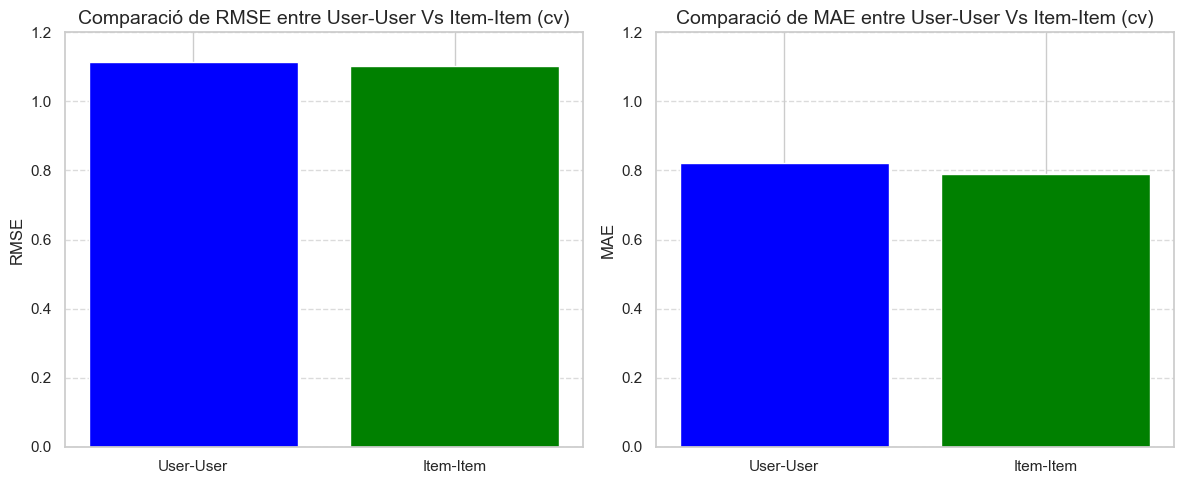

In [43]:
models = ['User-User', 'Item-Item']  # Models a comparar: User-User i Item-Item
rmse_values = [cv_cosinus_uu_rmse, cv_cosinus_i_rmse]  # RMSE per User-User i Item-Item
mae_values = [cv_cosinus_uu_mae, cv_cosinus_i_mae]   # MAE per User-User i Item-Item

# Gràfic 1: Comparació de RMSE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Subgràfic 1 (a la primera posició, 1 fila i 2 columnes)
plt.bar(models, rmse_values, color=['blue', 'green'])  # Dibuixar el gràfic de barres per RMSE
plt.title('Comparació de RMSE entre User-User Vs Item-Item (cv)', fontsize=14)  # Títol del gràfic
plt.ylabel('RMSE', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1.2)  # Limitar l'eix Y entre 0 i 1.2 per una millor visualització
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella en l'eix Y

# Gràfic 2: Comparació de MAE
plt.subplot(1, 2, 2)  # Subgràfic 2 (a la segona posició, 1 fila i 2 columnes)
plt.bar(models, mae_values, color=['blue', 'green'])  # Dibuixar el gràfic de barres per MAE
plt.title('Comparació de MAE entre User-User Vs Item-Item (cv)', fontsize=14)  # Títol del gràfic
plt.ylabel('MAE', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1.2)  # Limitar l'eix Y entre 0 i 1.2 per una millor visualització
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella en l'eix Y

# Ajustar els espais i mostrar els gràfics
plt.tight_layout()  # Ajustar els espais perquè no es superposin els elements
plt.show()  # Mostrar els gràfics

<p style="font-size:30px;">RMSE i MAE per comparar User - User vs Item - Item vs SVD</p>

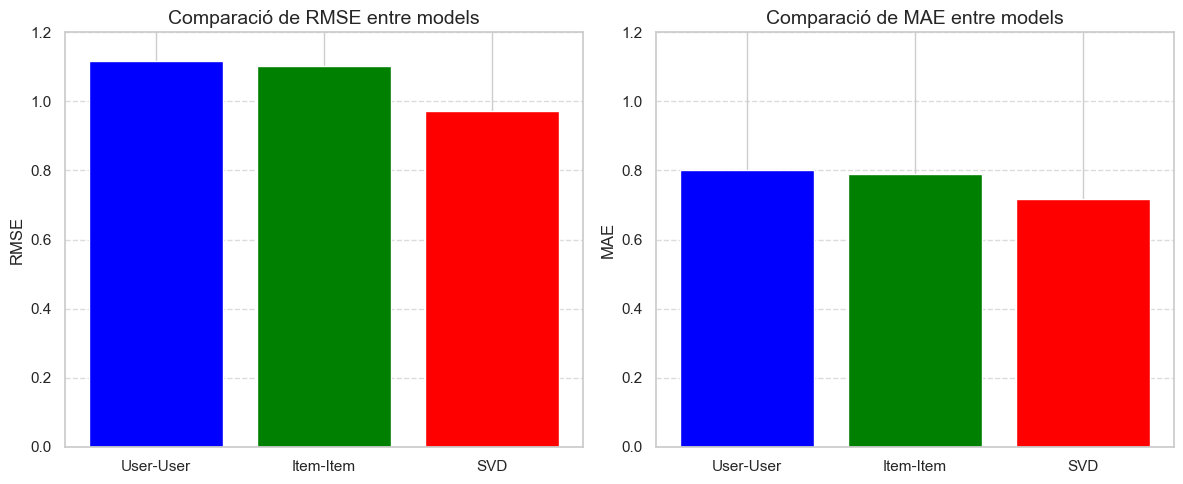

In [44]:
# U-U vs I-I vs SVD per COSINUS
# Afegir valors del model SVD
models = ['User-User', 'Item-Item', 'SVD']  # Models a comparar: User-User, Item-Item i SVD
rmse_values = [rmse_c_u, rmse_c_i, rmse_svd]  # RMSE per cada model (User-User, Item-Item, SVD)
mae_values = [mae_c_u, mae_c_i, mae_svd]     # MAE per cada model

# Crear gràfic comparatiu
plt.figure(figsize=(12, 5))  # Crear la figura amb un tamany de 12x5 polzades

# Gràfic 1: Comparació de RMSE
plt.subplot(1, 2, 1)  # Subgràfic 1 (a la primera posició, 1 fila i 2 columnes)
plt.bar(models, rmse_values, color=['blue', 'green', 'red'])  # Dibuixar el gràfic de barres per RMSE
plt.title('Comparació de RMSE entre models', fontsize=14)  # Títol del gràfic
plt.ylabel('RMSE', fontsize=12)  # Etiqueta de l'eix Y
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella en l'eix Y
plt.ylim(0, 1.2)  # Limitar l'eix Y entre 0 i 1.2 per una millor visualització

# Gràfic 2: Comparació de MAE
plt.subplot(1, 2, 2)  # Subgràfic 2 (a la segona posició, 1 fila i 2 columnes)
plt.bar(models, mae_values, color=['blue', 'green', 'red'])  # Dibuixar el gràfic de barres per MAE
plt.title('Comparació de MAE entre models', fontsize=14)  # Títol del gràfic
plt.ylabel('MAE', fontsize=12)  # Etiqueta de l'eix Y
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella en l'eix Y
plt.ylim(0, 1.2)  # Limitar l'eix Y entre 0 i 1.2 per una millor visualització

# Ajustar els espais i mostrar els gràfics
plt.tight_layout()  # Ajustar els espais perquè no es superposin els elements
plt.show()  # Mostrar els gràfics

<p style="font-size:30px;">RMSE i MAE per comparar User - User vs Item - Item vs SVD mitjançant Cross Validation</p>

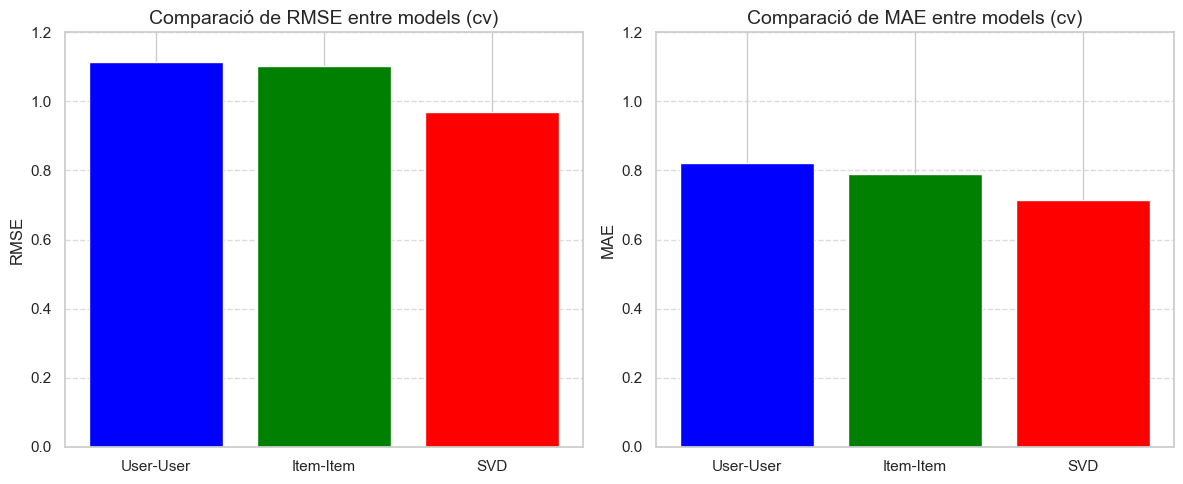

In [45]:
# Cross Validation U-U vs I-I vs SVD per COSINUS
# Afegir valors del model SVD
models = ['User-User', 'Item-Item', 'SVD']  # Models a comparar: User-User, Item-Item i SVD
rmse_values = [cv_cosinus_uu_rmse, cv_cosinus_i_rmse, cv_svd_rmse]  # RMSE per User-User, Item-Item i SVD
mae_values = [cv_cosinus_uu_mae, cv_cosinus_i_mae, cv_svd_mae]  # MAE per User-User, Item-Item i SVD

# Subgràfic 1: Comparació de RMSE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # Primer subgràfic (1 fila, 2 columnes, primer gràfic)
plt.bar(models, rmse_values, color=['blue', 'green', 'red'])  # Dibuixar el gràfic de barres per RMSE
plt.title('Comparació de RMSE entre models (cv)', fontsize=14)  # Títol del gràfic
plt.ylabel('RMSE', fontsize=12)  # Etiqueta de l'eix Y
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella a l'eix Y
plt.ylim(0, 1.2)  # Limitar l'eix Y entre 0 i 1.2 per una millor visualització

# Subgràfic 2: Comparació de MAE
plt.subplot(1, 2, 2)  # Segon subgràfic (1 fila, 2 columnes, segon gràfic)
plt.bar(models, mae_values, color=['blue', 'green', 'red'])  # Dibuixar el gràfic de barres per MAE
plt.title('Comparació de MAE entre models (cv)', fontsize=14)  # Títol del gràfic
plt.ylabel('MAE', fontsize=12)  # Etiqueta de l'eix Y
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella a l'eix Y
plt.ylim(0, 1.2)  # Limitar l'eix Y entre 0 i 1.2 per una millor visualització

# Ajustar els espais i mostrar els gràfics
plt.tight_layout()  # Ajustar els espais perquè no es superposin els elements
plt.show()  # Mostrar els gràfics


<p style="font-size:30px;">Comparació de la precisió i el recall AVG de cada model</p>

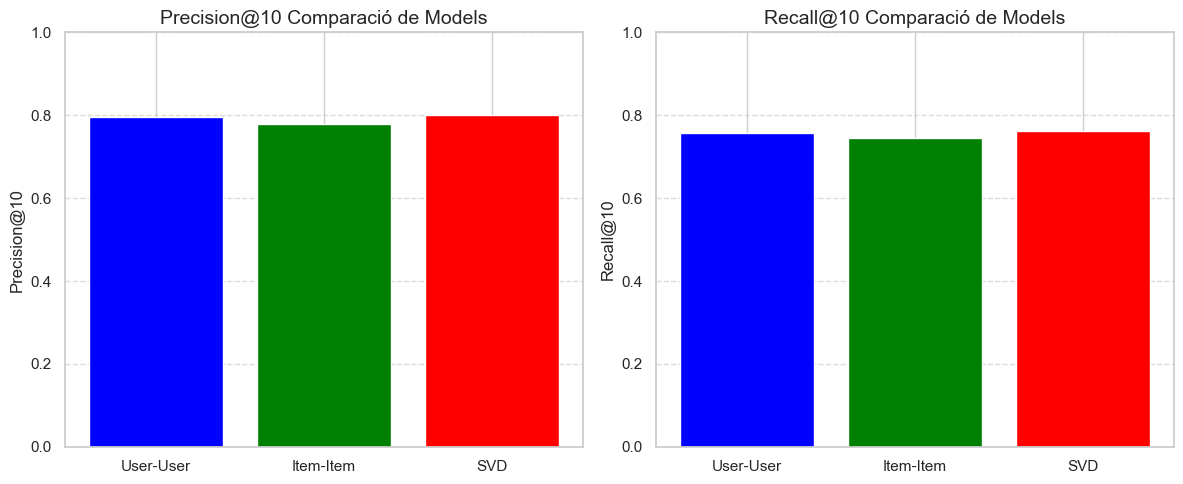

In [46]:
# Dades d'exemple per a gràfics (canviar per valors reals)
models = ['User-User', 'Item-Item', 'SVD']  # Models a comparar: User-User, Item-Item i SVD
precision_values = [avg_precision_c_u, avg_precision_c_i, avg_precision_svd]  # Sustituir avg_precision amb el valor real de SVD
recall_values = [avg_recall_c_u, avg_recall_c_i, avg_recall_svd]  # Sustituir avg_recall amb el valor real de SVD

# Gràfic comparatiu
plt.figure(figsize=(12, 5))  # Crear la figura amb una mida de 12x5 polzades

# Subgràfic 1: Comparació de Precision@10
plt.subplot(1, 2, 1)  # Primer subgràfic (1 fila, 2 columnes, primer gràfic)
plt.bar(models, precision_values, color=['blue', 'green', 'red'])  # Dibuixar el gràfic de barres per Precision@10
plt.title('Precision@10 Comparació de Models', fontsize=14)  # Títol del gràfic
plt.ylabel('Precision@10', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1)  # Limitar l'eix Y entre 0 i 1 per a una millor comparació
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella a l'eix Y

# Subgràfic 2: Comparació de Recall@10
plt.subplot(1, 2, 2)  # Segon subgràfic (1 fila, 2 columnes, segon gràfic)
plt.bar(models, recall_values, color=['blue', 'green', 'red'])  # Dibuixar el gràfic de barres per Recall@10
plt.title('Recall@10 Comparació de Models', fontsize=14)  # Títol del gràfic
plt.ylabel('Recall@10', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1)  # Limitar l'eix Y entre 0 i 1 per a una millor comparació
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una graella a l'eix Y

# Ajustar els espais i mostrar els gràfics
plt.tight_layout()  # Ajustar els espais perquè no es superposin els elements
plt.show()  # Mostrar els gràfics

<p style="font-size:30px;">Comparació de la precisió i el recall de cada model en funció del nombre de k items que el sistema recomana</p>

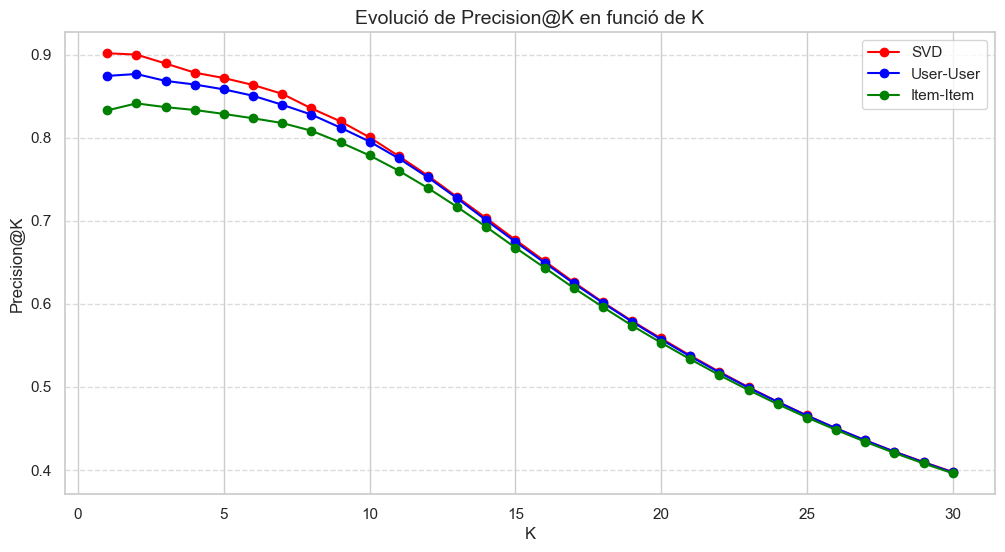

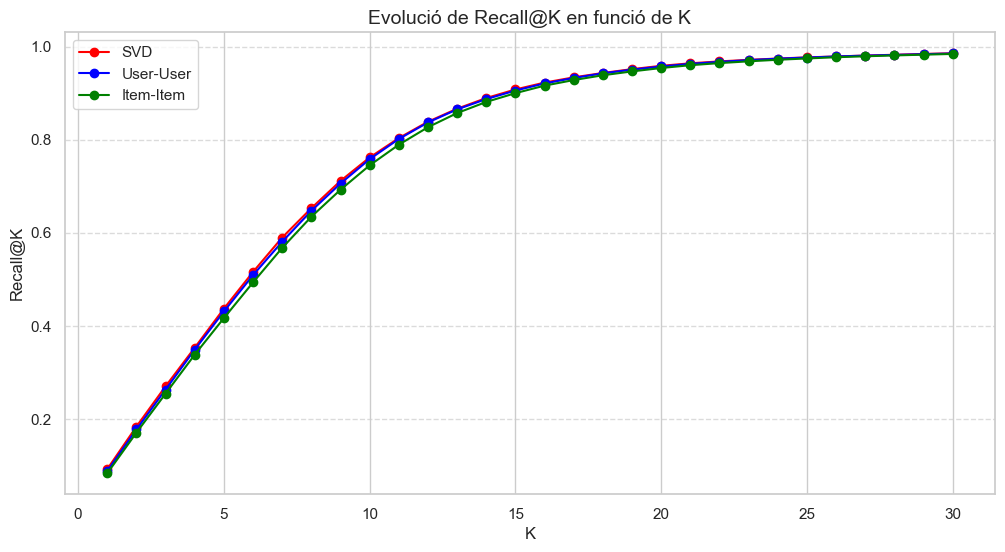

In [47]:
# Calcular Precision@K i Recall@K per al model SVD
precision_k_svd, recall_k_svd = precision_recall_by_k(pred, max_k=max_k)  # Calcular precision i recall per SVD
k_values = list(range(1, max_k + 1))  # Valors de K que van de 1 fins a max_k

# Graficar Precision@K
plt.figure(figsize=(12, 6))  # Definir la mida de la figura
plt.plot(k_values, precision_k_svd, label='SVD', marker='o', color='red')  # Graficar Precision per a SVD
plt.plot(k_values, precision_k_c_u, label='User-User', marker='o', color='blue')  # Graficar Precision per a User-User
plt.plot(k_values, precision_k_c_i, label='Item-Item', marker='o', color='green')  # Graficar Precision per a Item-Item
plt.title('Evolució de Precision@K en funció de K', fontsize=14)  # Títol del gràfic
plt.xlabel('K', fontsize=12)  # Etiqueta de l’eix X
plt.ylabel('Precision@K', fontsize=12)  # Etiqueta de l’eix Y
plt.legend()  # Mostrar llegenda per diferenciar els models
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una quadrícula a l’eix Y
plt.show()  # Mostrar el gràfic

# Graficar Recall@K
plt.figure(figsize=(12, 6))  # Definir la mida de la figura
plt.plot(k_values, recall_k_svd, label='SVD', marker='o', color='red')  # Graficar Recall per a SVD
plt.plot(k_values, recall_k_c_u, label='User-User', marker='o', color='blue')  # Graficar Recall per a User-User
plt.plot(k_values, recall_k_c_i, label='Item-Item', marker='o', color='green')  # Graficar Recall per a Item-Item
plt.title('Evolució de Recall@K en funció de K', fontsize=14)  # Títol del gràfic
plt.xlabel('K', fontsize=12)  # Etiqueta de l’eix X
plt.ylabel('Recall@K', fontsize=12)  # Etiqueta de l’eix Y
plt.legend()  # Mostrar llegenda per diferenciar els models
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegir una quadrícula a l’eix Y
plt.show()  # Mostrar el gràfic


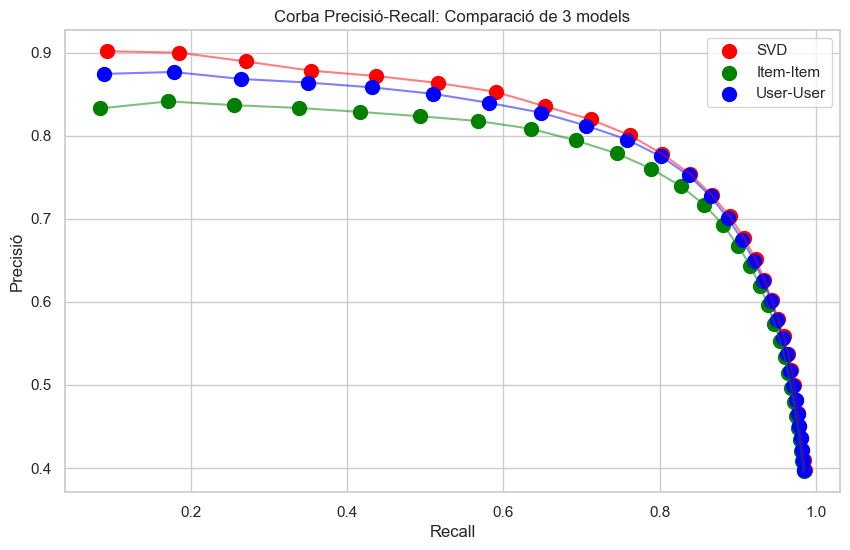

In [48]:
import matplotlib.pyplot as plt

# Llistes de Precision i Recall per a tres models (suposant que aquestes llistes ja estan definides)
# Els valors de Precision i Recall podrien venir de les prediccions en funció de K.
precision_model_1 = precision_k_svd
recall_model_1 = recall_k_svd

precision_model_2 = precision_k_c_i
recall_model_2 = recall_k_c_i

precision_model_3 = precision_k_c_u
recall_model_3 = recall_k_c_u

# Crear un gràfic de dispersió (scatter plot) per a cada model
plt.figure(figsize=(10, 6))

plt.scatter(recall_model_1, precision_model_1, color='red', label='SVD', marker='o', s=100)
plt.scatter(recall_model_2, precision_model_2, color='green', label='Item-Item', marker='o', s=100)
plt.scatter(recall_model_3, precision_model_3, color='blue', label='User-User', marker='o', s=100)

# Connectar els punts amb línies per a cada model
plt.plot(recall_model_1, precision_model_1, color='red', linestyle='-', alpha=0.5)
plt.plot(recall_model_2, precision_model_2, color='green', linestyle='-', alpha=0.5)
plt.plot(recall_model_3, precision_model_3, color='blue', linestyle='-', alpha=0.5)

# Afegir etiquetes i títol
plt.xlabel("Recall")
plt.ylabel("Precisió")
plt.title("Corba Precisió-Recall: Comparació de 3 models")

# Mostrar llegenda
plt.legend()

# Mostrar el gràfic
plt.grid(True)
plt.show()


Decidir odre models

In [49]:
from sklearn.metrics import auc

# Assegura't que els punts estiguin ordenats per recall
sorted_indices_1 = sorted(range(len(recall_model_1)), key=lambda i: recall_model_1[i])
sorted_recall_1 = [recall_model_1[i] for i in sorted_indices_1]
sorted_precision_1 = [precision_model_1[i] for i in sorted_indices_1]

sorted_indices_2 = sorted(range(len(recall_model_2)), key=lambda i: recall_model_2[i])
sorted_recall_2 = [recall_model_2[i] for i in sorted_indices_2]
sorted_precision_2 = [precision_model_2[i] for i in sorted_indices_2]

sorted_indices_3 = sorted(range(len(recall_model_3)), key=lambda i: recall_model_3[i])
sorted_recall_3 = [recall_model_3[i] for i in sorted_indices_3]
sorted_precision_3 = [precision_model_3[i] for i in sorted_indices_3]

# Calcular l'àrea sota la corba Precisió-Recall
ap_model_1 = auc(sorted_recall_1, sorted_precision_1)
ap_model_2 = auc(sorted_recall_2, sorted_precision_2)
ap_model_3 = auc(sorted_recall_3, sorted_precision_3)

# Mostrar els resultats
print(f"Precisió Mitjana (AP) - SVD: {ap_model_1:.4f}")
print(f"Precisió Mitjana (AP) - Item-Item: {ap_model_2:.4f}")
print(f"Precisió Mitjana (AP) - User-User: {ap_model_3:.4f}")


Precisió Mitjana (AP) - SVD: 0.7349
Precisió Mitjana (AP) - Item-Item: 0.7066
Precisió Mitjana (AP) - User-User: 0.7265


<p style="font-size:50px;">Càlcul d'errors en funció de la valoraciò real</p>

In [50]:
# Aquesta funció separa les prediccions en 5 llistes segons la valoració (r_ui)
def separa_prediccions(prediccio):
    arr1 = []  # Llista per les prediccions amb valoració 1.0
    arr2 = []  # Llista per les prediccions amb valoració 2.0
    arr3 = []  # Llista per les prediccions amb valoració 3.0
    arr4 = []  # Llista per les prediccions amb valoració 4.0
    arr5 = []  # Llista per les prediccions amb valoració 5.0
    
    # Per cada predicció, afegim el valor a la llista corresponent segons la valoració real (r_ui)
    for n in prediccio:
        if n.r_ui == 1.0:  # Si la valoració real és 1.0
            arr1.append(n)  # Afegim la predicció a arr1
        if n.r_ui == 2.0:  # Si la valoració real és 2.0
            arr2.append(n)  # Afegim la predicció a arr2
        if n.r_ui == 3.0:  # Si la valoració real és 3.0
            arr3.append(n)  # Afegim la predicció a arr3
        if n.r_ui == 4.0:  # Si la valoració real és 4.0
            arr4.append(n)  # Afegim la predicció a arr4
        if n.r_ui == 5.0:  # Si la valoració real és 5.0
            arr5.append(n)  # Afegim la predicció a arr5
    
    # Retorna les 5 llistes separades per les valoracions
    return arr1, arr2, arr3, arr4, arr5
def calcul_RMSE_MAE_5_ratings(l):
    rmse_list = []
    mae_list = []
    for n in range(len(l)):
        rmse_list.append(accuracy.rmse(l[n]))
        mae_list.append(accuracy.mae(l[n]))
    return rmse_list, mae_list

In [51]:
# Separar les prediccions en 5 conjunts
arr1, arr2, arr3, arr4, arr5 = separa_prediccions(pred)

# Calcular l'error RMSE i MAE per als diferents conjunts de prediccions
rmse1 = accuracy.rmse(arr1)
mae1 = accuracy.mae(arr1)
print("Errors RMSE predict 1.0", rmse1)
print("Errors MAE predict 1.0", mae1)

rmse2 = accuracy.rmse(arr2)
mae2 = accuracy.mae(arr2)
print("Errors RMSE predict 2.0", rmse2)
print("Errors MAE predict 2.0", mae2)

rmse3 = accuracy.rmse(arr3)
mae3 = accuracy.mae(arr3)
print("Errors RMSE predict 3.0", rmse3)
print("Errors MAE predict 3.0", mae3)

rmse4 = accuracy.rmse(arr4)
mae4 = accuracy.mae(arr4)
print("Errors RMSE predict 4.0", rmse4)
print("Errors MAE predict 4.0", mae4)

rmse5 = accuracy.rmse(arr5)
mae5 = accuracy.mae(arr5)
print("Errors RMSE predict 5.0", rmse5)
print("Errors MAE predict 5.0", mae5)

RMSE: 2.9463
MAE:  2.8944
Errors RMSE predict 1.0 2.946297617184992
Errors MAE predict 1.0 2.8944055365042987
RMSE: 1.9867
MAE:  1.9268
Errors RMSE predict 2.0 1.9866708068203518
Errors MAE predict 2.0 1.9267899181052723
RMSE: 1.1151
MAE:  1.0410
Errors RMSE predict 3.0 1.1150867909634623
Errors MAE predict 3.0 1.041006685662239
RMSE: 0.4141
MAE:  0.3384
Errors RMSE predict 4.0 0.4141156847793687
Errors MAE predict 4.0 0.33842317655514925
RMSE: 0.6996
MAE:  0.5952
Errors RMSE predict 5.0 0.6995802247216003
Errors MAE predict 5.0 0.5952084161671335


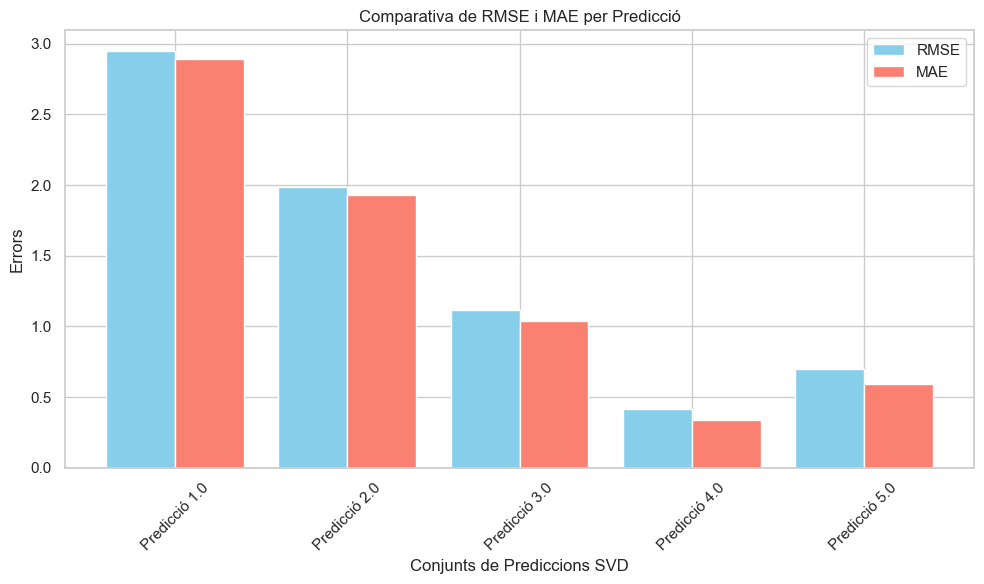

In [52]:
predicciones = ['Predicció 1.0', 'Predicció 2.0', 'Predicció 3.0', 'Predicció 4.0', 'Predicció 5.0']
rmse = [rmse1, rmse2, rmse3, rmse4, rmse5]
mae = [mae1, mae2, mae3, mae4, mae5]

# Posicions en l'eix X
x = np.arange(len(predicciones))

# Configuració de la gràfica
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, rmse, width=0.4, label='RMSE', color='skyblue')
plt.bar(x + 0.2, mae, width=0.4, label='MAE', color='salmon')

# Etiquetes i títol
plt.xticks(x, predicciones, rotation=45)
plt.xlabel('Conjunts de Prediccions SVD')
plt.ylabel('Errors')
plt.title('Comparativa de RMSE i MAE per Predicció')
plt.legend()

# Mostrar la gràfica
plt.tight_layout()
plt.grid(True)
plt.show()


RMSE: 3.1772
MAE:  3.0972
RMSE: 2.1944
MAE:  2.1052
RMSE: 1.2907
MAE:  1.1898
RMSE: 0.6318
MAE:  0.4832
RMSE: 0.8277
MAE:  0.6209


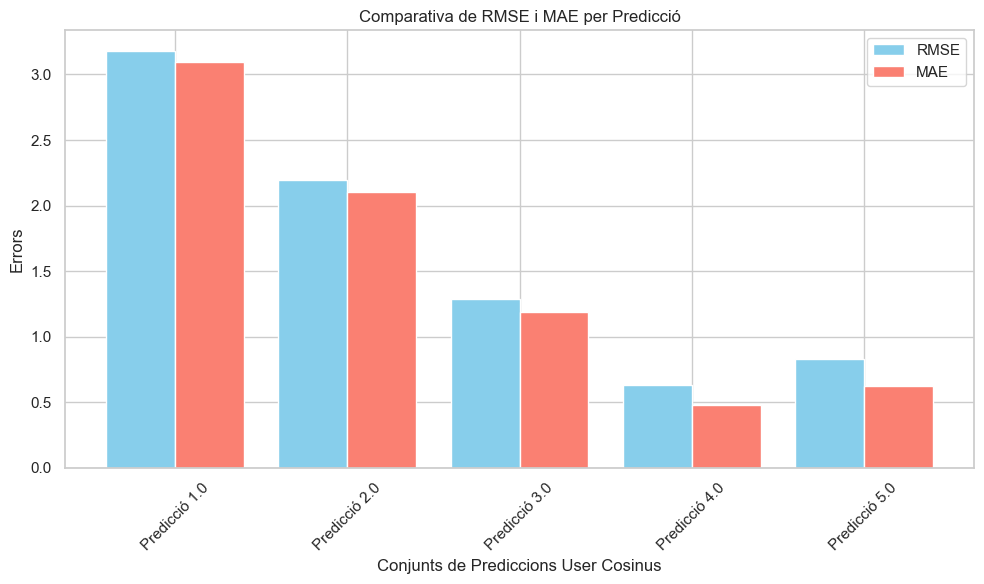

RMSE: 3.2182
MAE:  3.1818
RMSE: 2.1945
MAE:  2.1401
RMSE: 1.2673
MAE:  1.2076
RMSE: 0.5424
MAE:  0.3969
RMSE: 0.7924
MAE:  0.6936


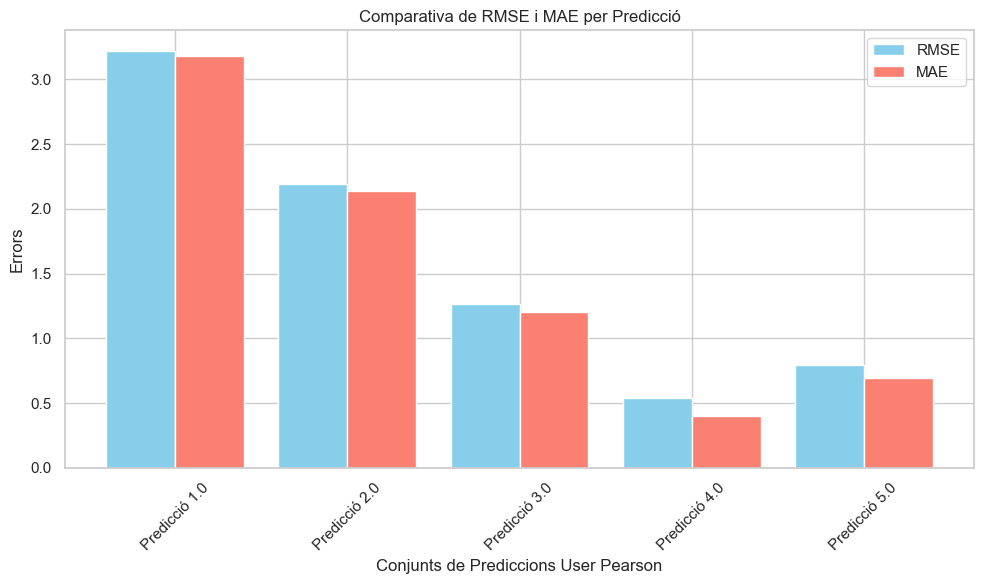

RMSE: 3.2011
MAE:  3.1313
RMSE: 2.2307
MAE:  2.1604
RMSE: 1.2972
MAE:  1.2174
RMSE: 0.5553
MAE:  0.4323
RMSE: 0.7983
MAE:  0.6138


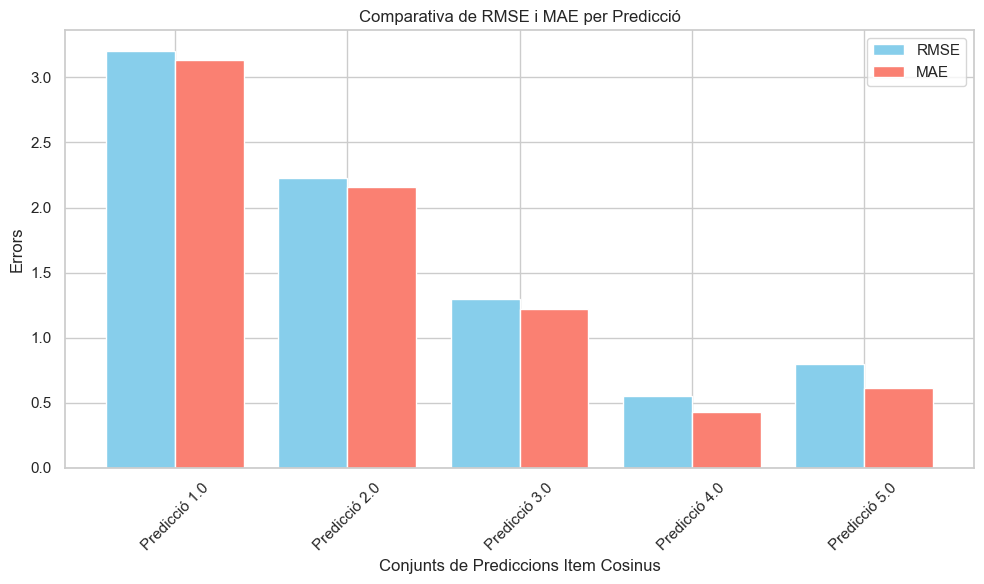

RMSE: 3.2566
MAE:  3.2376
RMSE: 2.2499
MAE:  2.2205
RMSE: 1.2862
MAE:  1.2465
RMSE: 0.4498
MAE:  0.3412
RMSE: 0.7777
MAE:  0.7040


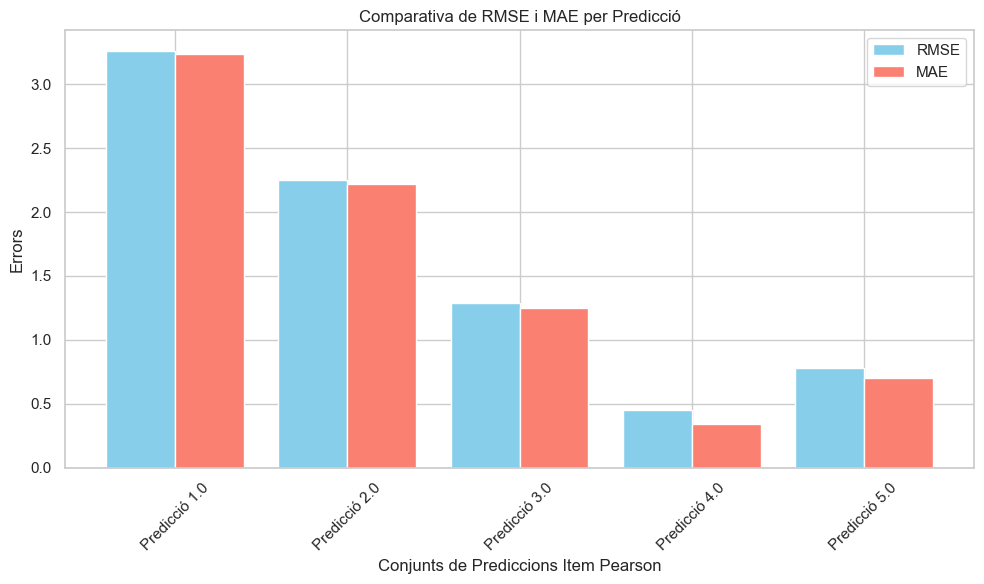

RMSE: 2.9463
MAE:  2.8944
RMSE: 1.9867
MAE:  1.9268
RMSE: 1.1151
MAE:  1.0410
RMSE: 0.4141
MAE:  0.3384
RMSE: 0.6996
MAE:  0.5952


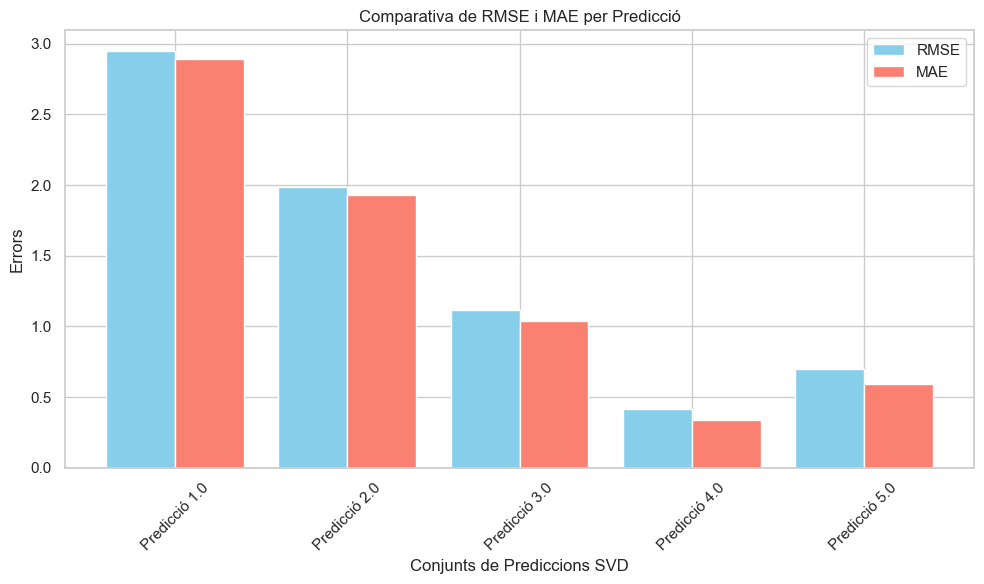

In [53]:
# Definició dels noms dels models i les seves prediccions
predicions_all_models_nom = ['User Cosinus', 'User Pearson', 'Item Cosinus', 'Item Pearson', 'SVD']
# Llista de les prediccions corresponents a cadascun dels models
predicions_all_models = [predictions_cosinus_u, predictions_pearson_u, predictions_cosinus_i, predictions_pearson_i, pred]

# Iterem sobre tots els models (5 en total)
for n in range(5):
    # Obtenim el nom del model i les seves prediccions
    name = predicions_all_models_nom[n]
    predd = predicions_all_models[n]
    
    # Separa les prediccions per les valoracions (1.0, 2.0, 3.0, 4.0, 5.0)
    arr1, arr2, arr3, arr4, arr5 = separa_prediccions(predd)
    rmse_list, mae_list = calcul_RMSE_MAE_5_ratings([arr1, arr2, arr3, arr4, arr5]) # Calcula RMSE i MAE per cada grup de valoracions (1.0 a 5.0)
    
    # Definició de les posicions en l'eix X (les valoracions)
    predicciones = ['Predicció 1.0', 'Predicció 2.0', 'Predicció 3.0', 'Predicció 4.0', 'Predicció 5.0']
    x = np.arange(len(predicciones))  # Generem una seqüència de posicions per a les valoracions
    
    plt.figure(figsize=(10, 6))
    plt.bar(x - 0.2, rmse_list, width=0.4, label='RMSE', color='skyblue') # Representem els errors RMSE en el gràfic
    plt.bar(x + 0.2, mae_list, width=0.4, label='MAE', color='salmon') # Representem els errors MAE en el gràfic
    
    # Afegim les etiquetes i el títol de la gràfica
    plt.xticks(x, predicciones, rotation=45)  # Etiquetem les valoracions (1.0, 2.0, etc.)
    plt.xlabel(f'Conjunts de Prediccions {name}')  # Nom del model
    plt.ylabel('Errors')  # Etiqueta de l'eix Y
    plt.title('Comparativa de RMSE i MAE per Predicció')  # Títol de la gràfica
    plt.legend()  # Afegim la llegenda
    
    # Ajustem la disposició de la gràfica i afegim una graella per millorar la llegibilitat
    plt.tight_layout()
    plt.grid(True)
    
    # Mostrem la gràfica
    plt.show()


<p style="font-size:50px;">Altres Proves</p>

<p style="font-size:30px;">Coincidència en les recomanacions</p>

In [54]:
from heapq import nlargest
from collections import defaultdict

def top_k_items(predictions, k=100):
    user_top_k = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_top_k[uid].append((iid, est))
    # Ordenar por estimación y seleccionar los k mejores
    for uid in user_top_k:
        user_top_k[uid] = [iid for iid, _ in nlargest(k, user_top_k[uid], key=lambda x: x[1])]
    return user_top_k

# Obtener las mejores predicciones para cada modelo
top_k_cosinus_i = top_k_items(predictions_cosinus_i, k=10)
top_k_cosinus_u = top_k_items(predictions_cosinus_u, k=10)
top_k_pearson_u = top_k_items(predictions_pearson_u, k=10)
top_k_pearson_i = top_k_items(predictions_pearson_i, k=10)

# Comparar intersecciones (ejemplo para dos modelos)
def personalization_analysis(top_k_1, top_k_2):
    overlap_counts = []
    for user in top_k_1:
        if user in top_k_2:
            overlap_counts.append(len(set(top_k_1[user]).intersection(top_k_2[user])))
    return sum(overlap_counts) / len(overlap_counts) if overlap_counts else 0

overlap_cosinus = personalization_analysis(top_k_cosinus_u, top_k_cosinus_i)
print(f"Porcentaje de ítems comunes entre Cosinus User y Item: {overlap_cosinus}")


Porcentaje de ítems comunes entre Cosinus User y Item: 7.297402597402598


In [119]:
import random

# Seleccionar 5 usuaris aleatoris de les prediccions
def get_random_users(predictions, n=5):
    users = list(set([uid for uid, _, _, _, _ in predictions]))
    return random.sample(users, n)

# Calcular el percentatge d'ítems comuns entre les recomanacions dels models
def compare_model_recommendations(users, top_k1, top_k2):
    overlaps = {}
    for user in users:
        cnt = 0
        if user in top_k1 and user in top_k2:
            set1 = top_k1[user]
            set2 = top_k2[user]
            for ii in set1:
                if ii in set2:
                    cnt+=1
            overlaps[user] = cnt / len(set1) * 100 if set1 else 0
    return overlaps

# Seleccionar 5 usuaris aleatoris
random_users = get_random_users(predictions_cosinus_u, n=10)

# Comparar les recomanacions entre models per als usuaris seleccionats
overlap_user_user_item_item = compare_model_recommendations(random_users, top_k_cosinus_u, top_k_cosinus_i)
overlap_user_user_svd = compare_model_recommendations(random_users, top_k_cosinus_u, top_k_items(pred, k=10))
overlap_item_item_svd = compare_model_recommendations(random_users, top_k_cosinus_i, top_k_items(pred, k=10))

# Imprimir els resultats
for user in random_users:
    print(f"Usuari: {user}")
    print(f"- Percentatge d'ítems comuns entre User-User i Item-Item: {overlap_user_user_item_item.get(user, 0):.2f}%")
    print(f"- Percentatge d'ítems comuns entre User-User i SVD: {overlap_user_user_svd.get(user, 0):.2f}%")
    print(f"- Percentatge d'ítems comuns entre Item-Item i SVD: {overlap_item_item_svd.get(user, 0):.2f}%")
    print()

Usuari: A2OTQMC69J8MUI
- Percentatge d'ítems comuns entre User-User i Item-Item: 90.00%
- Percentatge d'ítems comuns entre User-User i SVD: 90.00%
- Percentatge d'ítems comuns entre Item-Item i SVD: 90.00%

Usuari: A2RN2AO4BE6F4K
- Percentatge d'ítems comuns entre User-User i Item-Item: 70.00%
- Percentatge d'ítems comuns entre User-User i SVD: 100.00%
- Percentatge d'ítems comuns entre Item-Item i SVD: 70.00%

Usuari: A212MDP6K4VJS5
- Percentatge d'ítems comuns entre User-User i Item-Item: 80.00%
- Percentatge d'ítems comuns entre User-User i SVD: 90.00%
- Percentatge d'ítems comuns entre Item-Item i SVD: 80.00%

Usuari: A2ME89MSWVG9NF
- Percentatge d'ítems comuns entre User-User i Item-Item: 80.00%
- Percentatge d'ítems comuns entre User-User i SVD: 100.00%
- Percentatge d'ítems comuns entre Item-Item i SVD: 80.00%

Usuari: A1PI8VBCXXSGC7
- Percentatge d'ítems comuns entre User-User i Item-Item: 20.00%
- Percentatge d'ítems comuns entre User-User i SVD: 80.00%
- Percentatge d'ítems c

<p style="font-size:30px;">Ítems més recomanats</p>

In [116]:
from collections import Counter

def item_counts_from_top_k(predictions, k=10, x=30):
    # Obtenir el diccionari amb els top k ítems per usuari
    user_top_k = top_k_items(predictions, k=k)
    
    # Comptar quantes vegades apareix cada ítem
    item_count = Counter()
    for items in user_top_k.values():
        item_count.update(items)
    
    # Obtenir els ítems que més es repeteixen
    most_common_items = item_count.most_common(x)
    return item_count, most_common_items

In [117]:
def plot_most_common_items(item_count, most_common_items, nom):
    # Recortar la llista per quedar-nos només amb els primers 30 ítems
    most_common_items = most_common_items[:30]

    # Extreure els ítems i els seus recompte
    items = [item for item, count in most_common_items]
    counts = [count for item, count in most_common_items]

    # Crear el gràfic
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts, color='skyblue')  # Canviat a bar per invertir els eixos
    plt.ylabel('Número d\'aparicions')
    plt.title(f'Top 30 Ítems més comuns de {nom}')
    plt.xticks(rotation=45)  # Girar les etiquetes de l\'eix X si els noms dels ítems són llargs
    plt.show()

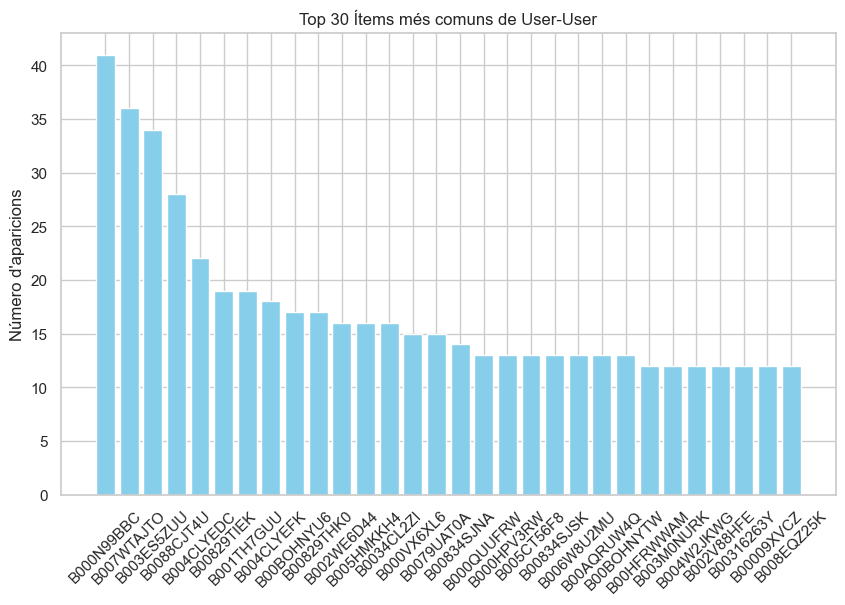

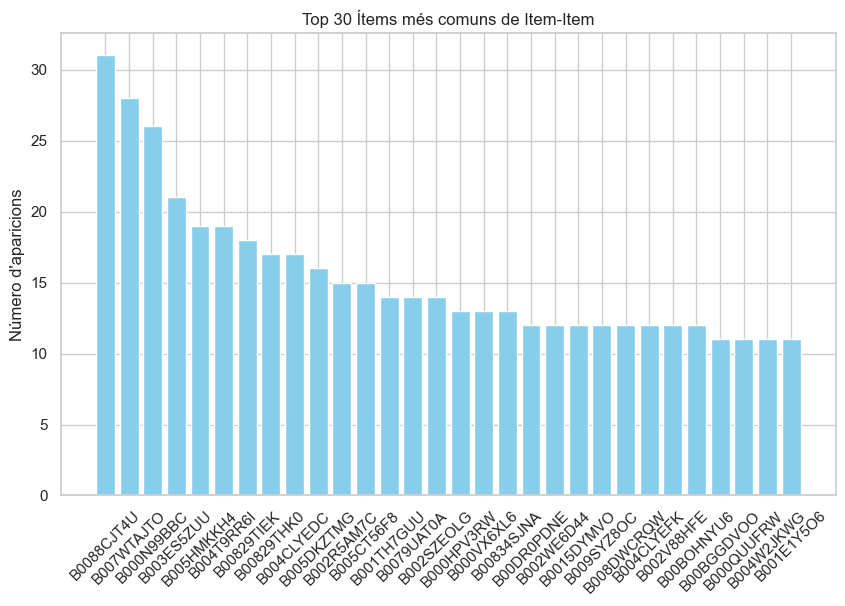

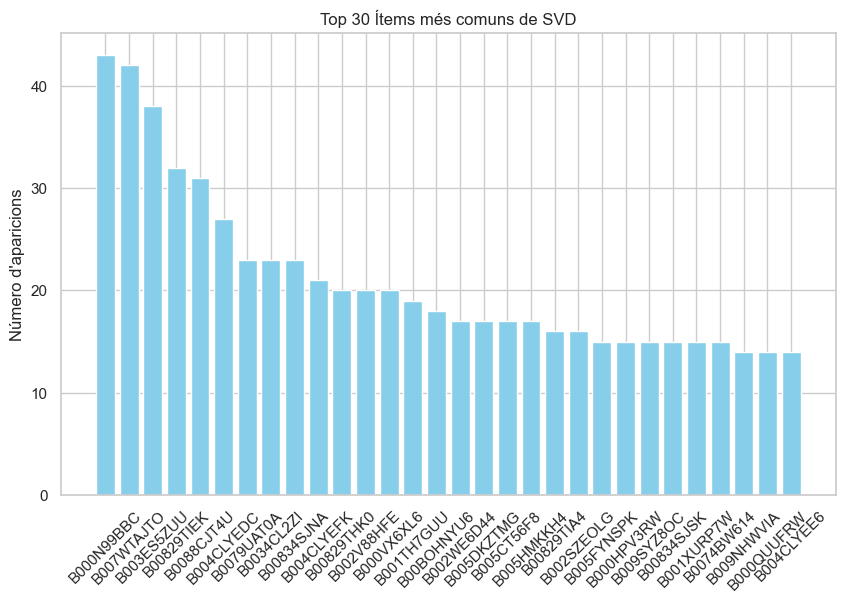

In [118]:
llista_prediccions = [(predictions_cosinus_u, 'User-User'), (predictions_cosinus_i, 'Item-Item'), (pred, 'SVD')]
for p in llista_prediccions:    
    # Cridar la funció per obtenir els ítems més comuns
    item_count, most_common_items = item_counts_from_top_k(p[0], k=10, x=30)
    # Cridar la funció de graficat amb els primers 30 ítems
    plot_most_common_items(item_count, most_common_items, p[1])

<p style="font-size:30px;">Comparació en el tempsd'execució de cada model</p>

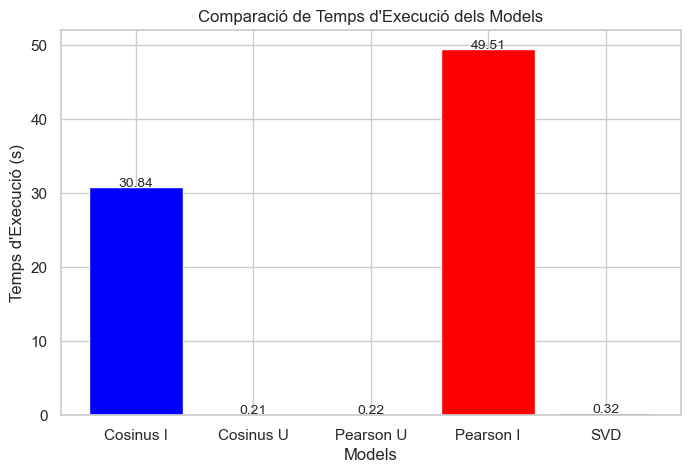

In [57]:
#TEMPS D'EXECUCIÓ DELS MODELS
models = ['Cosinus I', 'Cosinus U', 'Pearson U', 'Pearson I', 'SVD']
execution_times = [time_cosinus_i, time_cosinus_u, time_pearson_u, time_pearson_i, time_svd]

# Crear el gràfic de barres
plt.figure(figsize=(8, 5))  # Ajustar la mida del gràfic
plt.bar(models, execution_times, color=['blue', 'orange', 'green', 'red', 'purple'], alpha=1)

# Etiquetes i títol
plt.xlabel('Models')
plt.ylabel('Temps d\'Execució (s)')
plt.title('Comparació de Temps d\'Execució dels Models')

# Mostrar els valors dels temps sobre les barres
for i, time in enumerate(execution_times):
    plt.text(i, time + 0.01, f'{time:.2f}', ha='center', fontsize=10)

# Mostrar el gràfic
plt.show()

<p style="font-size:30px;">Dimensions del conjunt de dades alternatives</p>

In [59]:
unics = filtered_dataset['userId'].unique()

np.random.seed(42) #Al estar agafant usuaris aleatòris, cal assegurar la reproductibilitat de les dades.

un_terç = len(unics) // 3
dos_terços = len(unics) // 3 * 2

usuaris_1_terç = np.random.choice(unics, size=un_terç, replace=False) #Seleccionem un terç dels usuaris

dataset_1_terç = filtered_dataset[filtered_dataset['userId'].isin(usuaris_1_terç)]

usuaris_2_terços = np.random.choice(unics, size=dos_terços, replace=False) #Seleccionem dos terços dels usuaris

dataset_2_terços = filtered_dataset[filtered_dataset['userId'].isin(usuaris_2_terços)]

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0787
RMSE: 0.8911
RMSE: 1.1144
RMSE: 1.1225
RMSE: 0.9620
RMSE: 0.9808


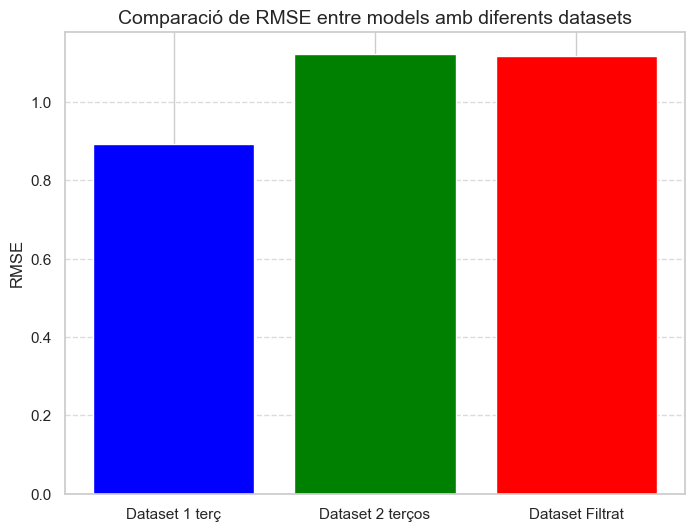

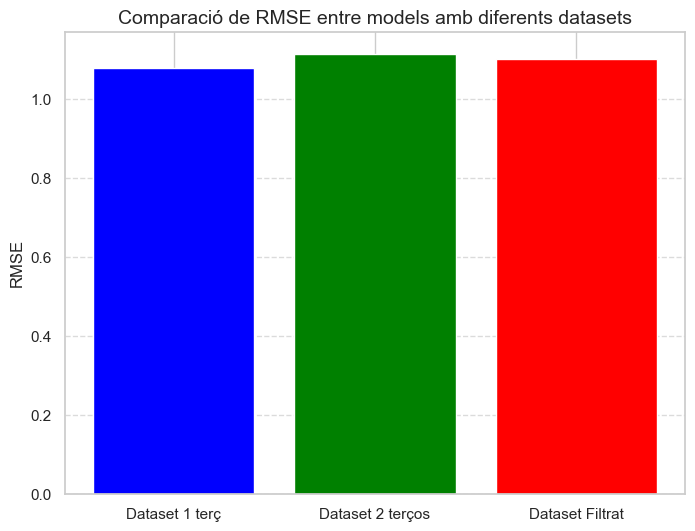

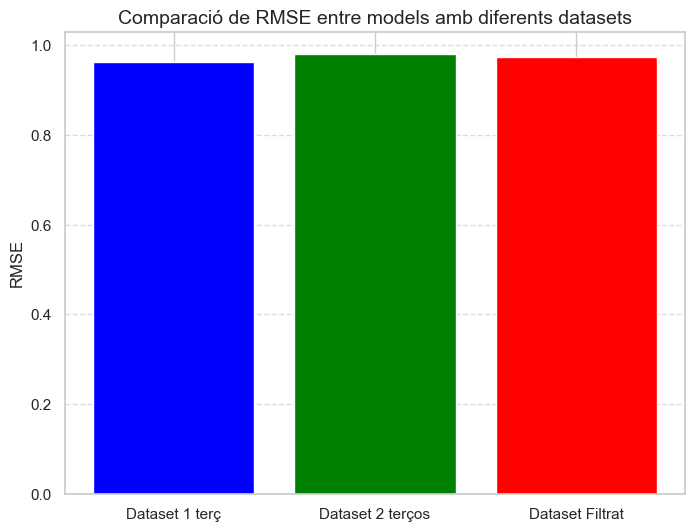

In [61]:
#Divisió dels datasets

data_1_terç = Dataset.load_from_df(dataset_1_terç[['userId','productId', 'rating']], reader)

data_2_terços = Dataset.load_from_df(dataset_2_terços[['userId','productId', 'rating']], reader)

train_1,test_1 = train_test_split(data_1_terç, test_size=0.2, random_state = 40)

train_2,test_2 = train_test_split(data_2_terços, test_size=0.2, random_state = 36)

mmmodel_cosinus_i = KNNBasic(k=5, sim_options=sim_options_cosinus_items)  # Model Item-Item amb similitud cosinus
mmmodel_cosinus_u = KNNBasic(k=5, sim_options=sim_options_cosinus)  # Model User-User amb similitud cosinus
mmmodel_pearson_u = KNNBasic(k=4, sim_options=sim_options_pearson)  # Model User-User amb similitud Pearson
mmmodel_pearson_i = KNNBasic(k=4, sim_options=sim_options_pearson_items)  # Model Item-Item amb similitud Pearson
mm_svd = SVD(n_factors = 6) 
#Entrenament dels models

mmmodel_cosinus_u.fit(train_1)
mmmodel_cosinus_i.fit(train_1)
mmmodel_cosinus_u.fit(train_2)
mmmodel_cosinus_i.fit(train_2)
mm_svd.fit(train_1)
mm_svd.fit(train_2)

#Càlcul de prediccions

predictions_cosinus_i_500 = mmmodel_cosinus_i.test(test_1)
predictions_cosinus_u_500 = mmmodel_cosinus_u.test(test_1)
predictions_cosinus_i_1000 = mmmodel_cosinus_i.test(test_2)
predictions_cosinus_u_1000 = mmmodel_cosinus_u.test(test_2)
pred_500 = mm_svd.test(test_1)
pred_1000 = mm_svd.test(test_2)

#Calcular els errors (RMSE)

rmse_c_i_500 = accuracy.rmse(predictions_cosinus_i_500)
rmse_c_u_500 = accuracy.rmse(predictions_cosinus_u_500)
rmse_c_i_1000 = accuracy.rmse(predictions_cosinus_i_1000)
rmse_c_u_1000 = accuracy.rmse(predictions_cosinus_u_1000)
rmse_svd_500 = accuracy.rmse(pred_500)
rmse_svd_1000 = accuracy.rmse(pred_1000)

models = ['Dataset 1 terç', 'Dataset 2 terços', 'Dataset Filtrat']
valors_rmse_u = [rmse_c_u_500, rmse_c_u_1000, rmse_c_u]
valors_rmse_i = [rmse_c_i_500,rmse_c_i_1000, rmse_c_i]
valors_rmse_svd = [rmse_svd_500,rmse_svd_1000, rmse_svd]

# Graficar comparació de RMSE

#USER USER
plt.figure(figsize=(8, 6))
plt.bar(models, valors_rmse_u, color=['blue', 'green', 'red'])
plt.title('Comparació de RMSE entre models amb diferents datasets', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#ITEM ITEM
plt.figure(figsize=(8, 6))
plt.bar(models, valors_rmse_i, color=['blue', 'green', 'red'])
plt.title('Comparació de RMSE entre models amb diferents datasets', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#SVD
plt.figure(figsize=(8, 6))
plt.bar(models, valors_rmse_svd, color=['blue', 'green', 'red'])
plt.title('Comparació de RMSE entre models amb diferents datasets', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0519
RMSE: 0.8949
RMSE: 1.1048
RMSE: 1.1100
RMSE: 0.9222
RMSE: 0.9743


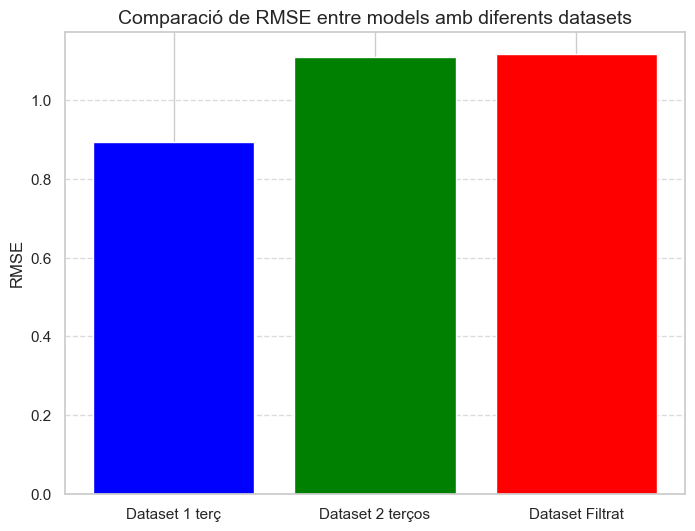

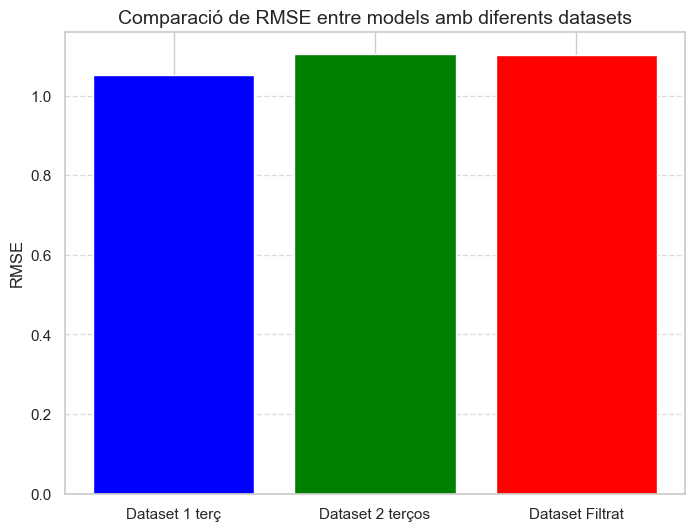

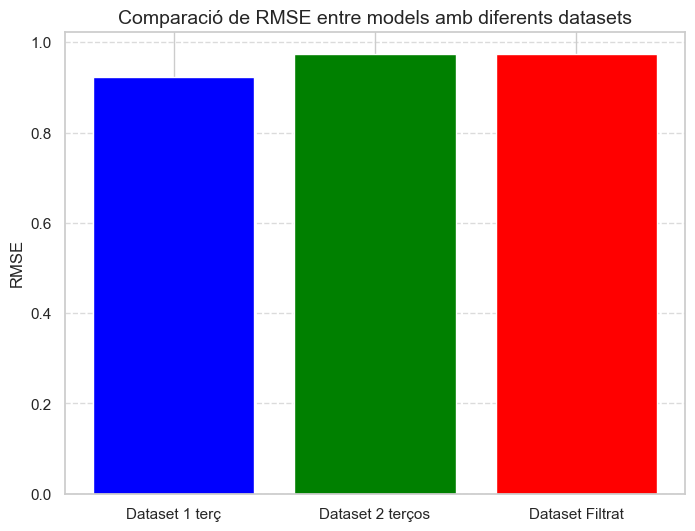

In [62]:
unics = filtered_dataset['productId'].unique()

np.random.seed(42) #Al estar agafant usuaris aleatòris, cal assegurar la reproductibilitat de les dades.

un_terç = len(unics) // 3
dos_terços = len(unics) // 3 * 2

items_1_terç = np.random.choice(unics, size=un_terç, replace=False) #Seleccionem un terç dels items

dataset_1_terç = filtered_dataset[filtered_dataset['productId'].isin(items_1_terç)]

items_2_terços = np.random.choice(unics, size=dos_terços, replace=False) #Seleccionem dos terços dels items

dataset_2_terços = filtered_dataset[filtered_dataset['productId'].isin(items_2_terços)]


#Divisió dels datasets

data_1_terç = Dataset.load_from_df(dataset_1_terç[['userId','productId', 'rating']], reader)

data_2_terços = Dataset.load_from_df(dataset_2_terços[['userId','productId', 'rating']], reader)

train_1,test_1 = train_test_split(data_1_terç, test_size=0.2)

train_2,test_2 = train_test_split(data_2_terços, test_size=0.2)

#Entrenament dels models

model_cosinus_u.fit(train_1)
model_cosinus_i.fit(train_1)
model_cosinus_u.fit(train_2)
model_cosinus_i.fit(train_2)
svd.fit(train_1)
svd.fit(train_2)

#Càlcul de prediccions

predictions_cosinus_i_500 = model_cosinus_i.test(test_1)
predictions_cosinus_u_500 = model_cosinus_u.test(test_1)
predictions_cosinus_i_1000 = model_cosinus_i.test(test_2)
predictions_cosinus_u_1000 = model_cosinus_u.test(test_2)
pred_500 = svd.test(test_1)
pred_1000 = svd.test(test_2)

#Calcular els errors (RMSE)

rmse_c_i_500 = accuracy.rmse(predictions_cosinus_i_500)
rmse_c_u_500 = accuracy.rmse(predictions_cosinus_u_500)
rmse_c_i_1000 = accuracy.rmse(predictions_cosinus_i_1000)
rmse_c_u_1000 = accuracy.rmse(predictions_cosinus_u_1000)
rmse_svd_500 = accuracy.rmse(pred_500)
rmse_svd_1000 = accuracy.rmse(pred_1000)

models = ['Dataset 1 terç', 'Dataset 2 terços', 'Dataset Filtrat']
valors_rmse_u = [rmse_c_u_500, rmse_c_u_1000, rmse_c_u]
valors_rmse_i = [rmse_c_i_500,rmse_c_i_1000, rmse_c_i]
valors_rmse_svd = [rmse_svd_500,rmse_svd_1000, rmse_svd]

# Graficar comparació de RMSE

#USER USER
plt.figure(figsize=(8, 6))
plt.bar(models, valors_rmse_u, color=['blue', 'green', 'red'])
plt.title('Comparació de RMSE entre models amb diferents datasets', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#ITEM ITEM
plt.figure(figsize=(8, 6))
plt.bar(models, valors_rmse_i, color=['blue', 'green', 'red'])
plt.title('Comparació de RMSE entre models amb diferents datasets', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#SVD
plt.figure(figsize=(8, 6))
plt.bar(models, valors_rmse_svd, color=['blue', 'green', 'red'])
plt.title('Comparació de RMSE entre models amb diferents datasets', fontsize=14)
plt.ylabel('RMSE', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

<p style="font-size:50px;">Proves Descartades</p>

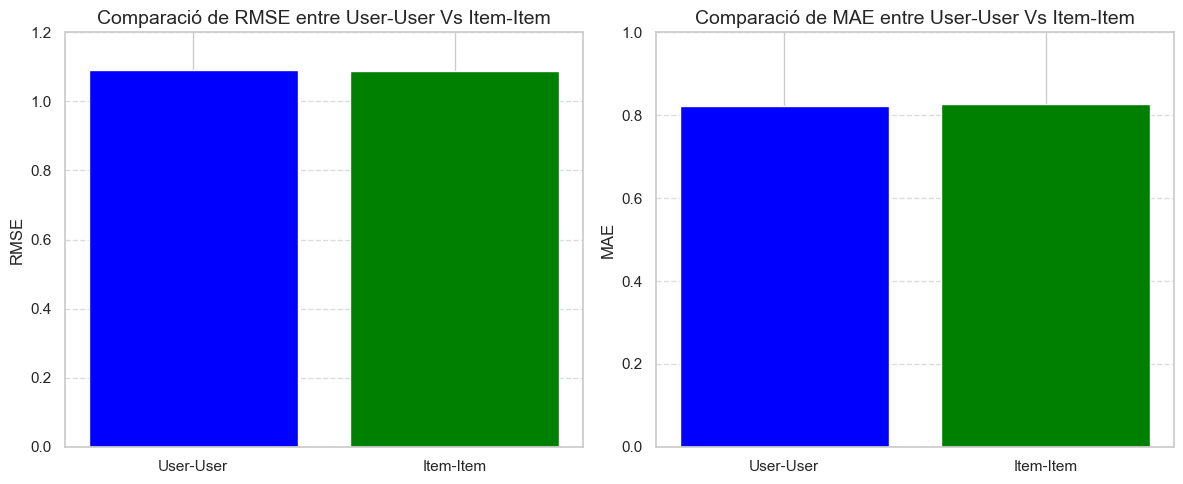

In [63]:
# Dades simulades de les mètriques
models = ['User-User', 'Item-Item']  # Els dos models a comparar
rmse_values = [cv_pearson_uu_rmse, cv_pearson_i_rmse]  # RMSE per als models User-User i Item-Item
mae_values = [cv_pearson_uu_mae, cv_pearson_i_mae]   # MAE per als models User-User i Item-Item

# Gràfic 1: Comparació de RMSE
plt.figure(figsize=(12, 5))  # Es crea una finestra de gràfic amb una mida especificada
plt.subplot(1, 2, 1)  # Divideix la finestra en 1 fila i 2 columnes, i selecciona la primera part
plt.bar(models, rmse_values, color=['blue', 'green'])  # Dibuixa les barres de RMSE
plt.title('Comparació de RMSE entre User-User Vs Item-Item', fontsize=14)  # Títol del gràfic
plt.ylabel('RMSE', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1.2)  # Limita l'escala de l'eix Y per a RMSE
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegim una graella horitzontal a l'eix Y

# Gràfic 2: Comparació de MAE
plt.subplot(1, 2, 2)  # Selecciona la segona part de la finestra per al segon gràfic
plt.bar(models, mae_values, color=['blue', 'green'])  # Dibuixa les barres de MAE
plt.title('Comparació de MAE entre User-User Vs Item-Item', fontsize=14)  # Títol del gràfic
plt.ylabel('MAE', fontsize=12)  # Etiqueta de l'eix Y
plt.ylim(0, 1)  # Limita l'escala de l'eix Y per a MAE
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegim una graella horitzontal a l'eix Y

# Mostrar els gràfics
plt.tight_layout()  # Ajusta el disseny per evitar solapaments
plt.show()  # Mostra els gràfics


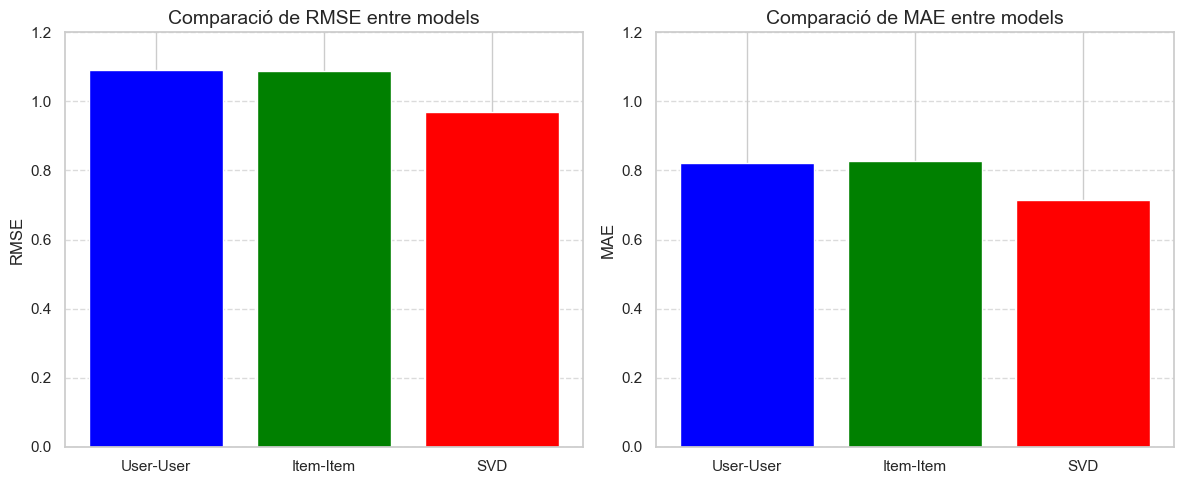

In [64]:
# Dades de validació creuada per als models User-User, Item-Item i SVD
# Afegir els valors per al model SVD
models = ['User-User', 'Item-Item', 'SVD']  # Els tres models que estem comparant
rmse_values = [cv_pearson_uu_rmse, cv_pearson_i_rmse, cv_svd_rmse]  # RMSE per als models User-User, Item-Item i SVD
mae_values = [cv_pearson_uu_mae, cv_pearson_i_mae, cv_svd_mae]  # MAE per als models User-User, Item-Item i SVD

# Crear un gràfic comparatiu
plt.figure(figsize=(12, 5))  # Creem una figura amb una mida de 12x5 polzades

# Gràfic 1: Comparació de RMSE
plt.subplot(1, 2, 1)  # Creem el primer gràfic en una finestra dividida en 1 fila i 2 columnes
plt.bar(models, rmse_values, color=['blue', 'green', 'red'])  # Dibuixem un gràfic de barres amb els valors de RMSE
plt.title('Comparació de RMSE entre models', fontsize=14)  # Títol del gràfic
plt.ylabel('RMSE', fontsize=12)  # Etiqueta de l'eix Y
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegim una graella en l'eix Y per millorar la llegibilitat
plt.ylim(0, 1.2)  # Establim els límits de l'eix Y entre 0 i 1.2 per mostrar l'escala dels errors RMSE

# Gràfic 2: Comparació de MAE
plt.subplot(1, 2, 2)  # Creem el segon gràfic en la segona columna
plt.bar(models, mae_values, color=['blue', 'green', 'red'])  # Dibuixem un gràfic de barres amb els valors de MAE
plt.title('Comparació de MAE entre models', fontsize=14)  # Títol del gràfic
plt.ylabel('MAE', fontsize=12)  # Etiqueta de l'eix Y
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Afegim una graella en l'eix Y
plt.ylim(0, 1.2)  # Establim els límits de l'eix Y entre 0 i 1.2 per mostrar l'escala dels errors MAE

# Ajustar l'espai per a una millor visualització
plt.tight_layout()  # Ajusta automàticament l'espai entre els gràfics per evitar el solapament de textos
plt.show()  # Mostra els gràfics


In [69]:
svd = SVD(n_factors = 10)
svd.fit(trainset)
pred10 = svd.test(testset)
svd = SVD(n_factors = 50)
svd.fit(trainset)
pred50 = svd.test(testset)
svd = SVD(n_factors = 100)
svd.fit(trainset)
pred100 = svd.test(testset)
svd = SVD(n_factors = 150)
svd.fit(trainset)
pred150 = svd.test(testset)
svd = SVD(n_factors = 200)
svd.fit(trainset)
pred200 = svd.test(testset)

In [70]:
precision_10_svd, recall_10_svd = precision_recall_by_k(pred10, max_k=max_k)
precision_50_svd, recall_50_svd = precision_recall_by_k(pred50, max_k=max_k)
precision_100_svd, recall_100_svd = precision_recall_by_k(pred100, max_k=max_k)
precision_150_svd, recall_150_svd = precision_recall_by_k(pred150, max_k=max_k)
precision_200_svd, recall_200_svd = precision_recall_by_k(pred200, max_k=max_k)
k_values = list(range(1, max_k + 1))

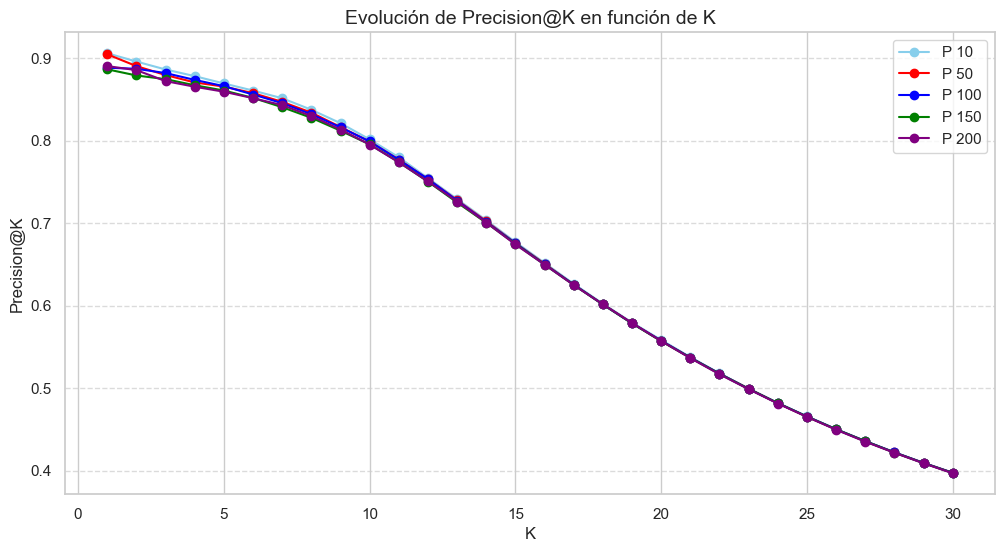

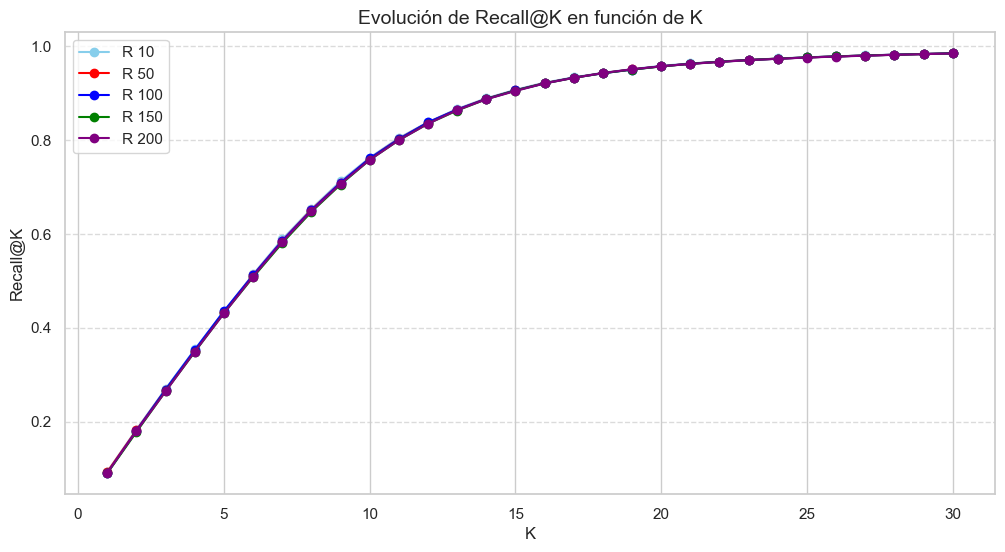

In [71]:
# Graficar Precision@K
plt.figure(figsize=(12, 6))
plt.plot(k_values, precision_10_svd, label='P 10', marker='o', color='skyblue')  
plt.plot(k_values, precision_50_svd, label='P 50', marker='o', color='red')        # Precision para SVD
plt.plot(k_values, precision_100_svd, label='P 100', marker='o', color='blue') # Precision para User-User
plt.plot(k_values, precision_150_svd, label='P 150', marker='o', color='green') # Precision para Item-Item
plt.plot(k_values, precision_200_svd, label='P 200', marker='o', color='purple') # Precision para SVD++
plt.title('Evolución de Precision@K en función de K', fontsize=14)
plt.xlabel('K', fontsize=12)
plt.ylabel('Precision@K', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Graficar Recall@K
plt.figure(figsize=(12, 6))
plt.plot(k_values, recall_10_svd, label='R 10', marker='o', color='skyblue')
plt.plot(k_values, recall_50_svd, label='R 50', marker='o', color='red')           # Recall para SVD
plt.plot(k_values, recall_100_svd, label='R 100', marker='o', color='blue')    # Recall para User-User
plt.plot(k_values, recall_150_svd, label='R 150', marker='o', color='green')   # Recall para Item-Item
plt.plot(k_values, recall_200_svd, label='R 200', marker='o', color='purple')   # Recall para SVD++
plt.title('Evolución de Recall@K en función de K', fontsize=14)
plt.xlabel('K', fontsize=12)
plt.ylabel('Recall@K', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

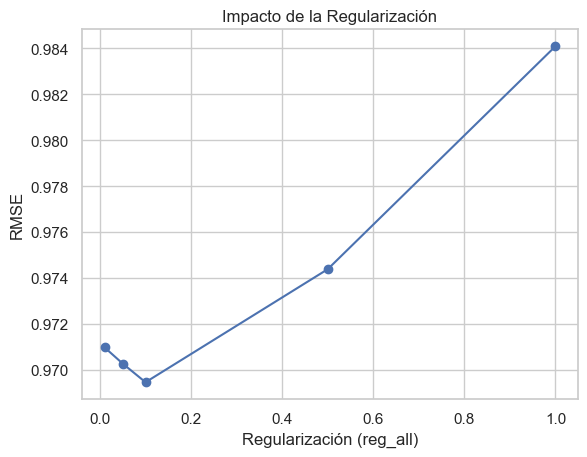

In [72]:
regs = [0.01, 0.05, 0.1, 0.5, 1]
rmses = []

for reg in regs:
    algo = SVD(n_factors=20, reg_all=reg)
    cv_results = cross_validate(algo, data, measures=['RMSE'], cv=kf, verbose=False)
    rmses.append(cv_results['test_rmse'].mean())

plt.plot(regs, rmses, marker='o')
plt.xlabel('Regularización (reg_all)')
plt.ylabel('RMSE')
plt.title('Impacto de la Regularización')
plt.show()